In [21]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


MOUNT THE DRIVE AND LOAD THE DATASET

In [22]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

In [23]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [24]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "lch_database"

In [25]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 lch_database/
 lch_harmonies_dataset/
 LCH_UTILS.ipynb
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 winter_summer_dataset/


In [27]:
def lch_to_rgb(img,wasByte):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      lch = LCHabColor(pixel[0],pixel[1],pixel[2]/(256./360) if wasByte else pixel[2])
      rgb = convert_color(lch,sRGBColor)
      new_img[i,j]=np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
      ctr+=1
      if ctr%10000==0:
        print("converting image to rgb, did",ctr,"pixels")
  return new_img

TEST THE CONVERSION FUNCTIONS

In [29]:
from torch.utils.data import Dataset

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path))
        horse_img = np.array(Image.open(horse_path))
        #!!!!! dans la base de données les teintes sont multipliées par 256./360. (pour rentrer sur un byte) (on garde ça comme ça.)
        zebra_img = (zebra_img/255.).astype(np.float16)
        horse_img = (horse_img/255.).astype(np.float16)

        zebra_img = torch.Tensor(np.moveaxis(zebra_img,-1,0)).to(torch.device("cuda:0"))
        horse_img = torch.Tensor(np.moveaxis(horse_img,-1,0)).to(torch.device("cuda:0"))


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"unknown_lch"),os.path.join(root_data,"mono_lch"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

(256, 256, 3)


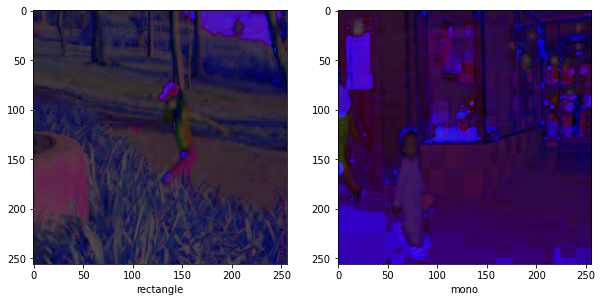

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


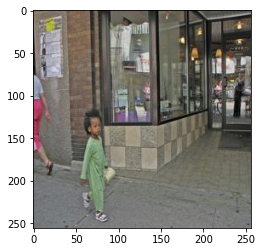

In [30]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1).reshape((256,256,3)))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1).reshape((256,256,3)))
plt.xlabel("mono")
plt.show()
plt.figure()
img_rgb = lch_to_rgb(np.moveaxis(np.array(summer.cpu()),0,-1).reshape((256,256,3))*255.,True)
plt.imshow(img_rgb)

#MODELS

In [31]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [32]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [33]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [34]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [35]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [36]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,2,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [37]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[ 0.4812,  0.2416,  0.2366,  ...,  0.6293,  0.7132, -0.2549],
         [ 0.1216,  0.1659,  0.2954,  ...,  0.2016, -0.0726, -0.0803],
         [ 0.3739,  0.2186,  0.2578,  ...,  0.3703,  0.3207, -0.0530],
         ...,
         [ 0.0547, -0.0226,  0.2783,  ...,  0.0182,  0.1616,  0.2723],
         [ 0.3430, -0.2261,  0.6144,  ..., -0.1446,  0.4779,  0.1513],
         [ 0.1916, -0.1685,  0.2017,  ...,  0.2738,  0.3162,  0.1894]],

        [[ 0.4110,  0.3240,  0.3013,  ...,  0.3253,  0.7363, -0.2554],
         [ 0.2588,  0.3703,  0.4429,  ...,  0.3051,  0.5177, -0.3620],
         [ 0.3928,  0.3791, -0.0284,  ...,  0.7162,  0.1731,  0.5268],
         ...,
         [ 0.2838,  0.1213,  0.2713,  ...,  0.0413,  0.3301, -0.1937],
         [-0.0273,  0.1996, -0.0884,  ...,  0.2343,  0.1403, -0.1147],
         [ 0.1326,  0.5212,  0.1948,  ...,  0.2019,  0.1017,  0.0191]]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [38]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [63]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):
      if i%2==0:
        #train the discriminators on their own
        with torch.cuda.amp.autocast():
          #adversarial loss for summer discriminator
          #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
          #basically estimating the distribution of summer images through this adversarial loss.
          fake_summer = gen_S(winter)
          #generator only generates c and h, concatenate L channel to that before passing to either loss function
          fake_summer = torch.cat([winter[0,:,:].reshape((1,256,256)),fake_summer],axis=0)
          pred_fake_summer = disc_S(fake_summer.detach())
          pred_real_summer = disc_S(summer)
          loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
          loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

          #adversarial loss for winter discriminator
          fake_winter = gen_W(summer)
          fake_winter = torch.cat([summer[0,:,:].reshape((1,256,256)),fake_winter],axis=0)
          pred_fake_winter = disc_W(fake_winter.detach())
          pred_real_winter = disc_W(winter)
          loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
          loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

          #final D loss
          D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


        opt_d.zero_grad()
        D_loss.backward()
        opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        fake_summer = torch.cat([winter[0,:,:].reshape((1,256,256)),fake_summer],axis=0)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        fake_winter = torch.cat([summer[0,:,:].reshape((1,256,256)),fake_winter],axis=0)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        reco_summer = torch.cat([fake_winter[0,:,:].reshape((1,256,256)),reco_summer],axis=0)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_W(fake_summer)
        reco_winter = torch.cat([fake_summer[0,:,:].reshape((1,256,256)),reco_winter],axis=0)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [70]:
#disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  0%|          | 1/2601 [00:00<05:56,  7.30it/s]

(256, 256, 3)
(256, 256, 3)


  0%|          | 4/2601 [00:00<04:08, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  0%|          | 6/2601 [00:00<03:57, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  0%|          | 10/2601 [00:00<03:48, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  0%|          | 12/2601 [00:01<03:52, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|          | 16/2601 [00:01<03:49, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7069685459136963 Gloss adv :  0.4930735230445862 D loss :  0.25136446952819824
(256, 256, 3)


  1%|          | 18/2601 [00:01<03:46, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|          | 22/2601 [00:01<03:45, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|          | 24/2601 [00:02<03:45, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|          | 28/2601 [00:02<03:46, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|          | 30/2601 [00:02<03:45, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7309504747390747 Gloss adv :  0.9819149971008301 D loss :  0.18259277939796448
(256, 256, 3)


  1%|▏         | 34/2601 [00:03<03:42, 11.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  1%|▏         | 36/2601 [00:03<03:41, 11.57it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 40/2601 [00:03<03:42, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 42/2601 [00:03<03:43, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 46/2601 [00:04<03:45, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4789206385612488 Gloss adv :  0.9288424253463745 D loss :  0.2620503902435303
(256, 256, 3)


  2%|▏         | 48/2601 [00:04<03:45, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 52/2601 [00:04<03:44, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 54/2601 [00:04<03:44, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 58/2601 [00:05<03:45, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  2%|▏         | 60/2601 [00:05<03:43, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8014256358146667 Gloss adv :  0.9973028898239136 D loss :  0.3087340295314789
(256, 256, 3)


  2%|▏         | 64/2601 [00:05<03:38, 11.61it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 66/2601 [00:05<03:40, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 70/2601 [00:06<03:41, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 72/2601 [00:06<03:40, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 76/2601 [00:06<03:44, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8838061094284058 Gloss adv :  0.47029489278793335 D loss :  0.3614686131477356
(256, 256, 3)


  3%|▎         | 78/2601 [00:06<03:42, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 82/2601 [00:07<03:43, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 84/2601 [00:07<03:42, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 88/2601 [00:07<03:41, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  3%|▎         | 90/2601 [00:07<03:41, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6985836029052734 Gloss adv :  0.8679162263870239 D loss :  0.3732181191444397
(256, 256, 3)


  4%|▎         | 94/2601 [00:08<03:34, 11.67it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▎         | 96/2601 [00:08<03:36, 11.55it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▍         | 100/2601 [00:08<03:39, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▍         | 102/2601 [00:08<03:39, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▍         | 106/2601 [00:09<03:41, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7184050679206848 Gloss adv :  0.9141749143600464 D loss :  0.2501086890697479
(256, 256, 3)


  4%|▍         | 108/2601 [00:09<03:39, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▍         | 112/2601 [00:09<03:39, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  4%|▍         | 114/2601 [00:10<03:41, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▍         | 118/2601 [00:10<03:40, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▍         | 120/2601 [00:10<03:39, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6332237124443054 Gloss adv :  1.0230283737182617 D loss :  0.2724987268447876
(256, 256, 3)


  5%|▍         | 124/2601 [00:10<03:33, 11.62it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▍         | 126/2601 [00:11<03:35, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▍         | 130/2601 [00:11<03:36, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▌         | 132/2601 [00:11<03:39, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▌         | 136/2601 [00:11<03:39, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7445302605628967 Gloss adv :  1.1757779121398926 D loss :  0.5584627985954285
(256, 256, 3)


  5%|▌         | 138/2601 [00:12<03:38, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  5%|▌         | 142/2601 [00:12<03:39, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 144/2601 [00:12<03:39, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 148/2601 [00:13<03:39, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 150/2601 [00:13<03:39, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5163812637329102 Gloss adv :  0.5012468099594116 D loss :  0.2078779935836792
(256, 256, 3)


  6%|▌         | 154/2601 [00:13<03:31, 11.58it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 156/2601 [00:13<03:34, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 160/2601 [00:14<03:37, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▌         | 162/2601 [00:14<03:36, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  6%|▋         | 166/2601 [00:14<03:41, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.9992137551307678 Gloss adv :  0.8038487434387207 D loss :  0.3842441737651825
(256, 256, 3)


  6%|▋         | 168/2601 [00:14<03:36, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 172/2601 [00:15<03:38, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 174/2601 [00:15<03:38, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 178/2601 [00:15<03:34, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 180/2601 [00:15<03:36, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5408294200897217 Gloss adv :  0.8976722955703735 D loss :  0.44847238063812256
(256, 256, 3)


  7%|▋         | 184/2601 [00:16<03:31, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 186/2601 [00:16<03:32, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 190/2601 [00:16<03:33, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  7%|▋         | 192/2601 [00:16<03:34, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 196/2601 [00:17<03:36, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4447365701198578 Gloss adv :  0.7341629266738892 D loss :  0.5039960145950317
(256, 256, 3)


  8%|▊         | 198/2601 [00:17<03:35, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 202/2601 [00:17<03:35, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 204/2601 [00:18<03:35, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 208/2601 [00:18<03:35, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 210/2601 [00:18<03:34, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.466046541929245 Gloss adv :  1.0316543579101562 D loss :  0.29691281914711
(256, 256, 3)


  8%|▊         | 214/2601 [00:18<03:28, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 216/2601 [00:19<03:31, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  8%|▊         | 220/2601 [00:19<03:34, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▊         | 222/2601 [00:19<03:32, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▊         | 226/2601 [00:20<03:34, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6905502080917358 Gloss adv :  0.8676066994667053 D loss :  0.2938842475414276
(256, 256, 3)


  9%|▉         | 228/2601 [00:20<03:32, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▉         | 232/2601 [00:20<03:32, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▉         | 234/2601 [00:20<03:33, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▉         | 238/2601 [00:21<03:33, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▉         | 240/2601 [00:21<03:33, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.008884072303772 Gloss adv :  0.7939693927764893 D loss :  0.29963839054107666
(256, 256, 3)


  9%|▉         | 244/2601 [00:21<03:28, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


  9%|▉         | 246/2601 [00:21<03:30, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|▉         | 250/2601 [00:22<03:32, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|▉         | 252/2601 [00:22<03:32, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|▉         | 256/2601 [00:22<03:34, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.9262333512306213 Gloss adv :  0.763630747795105 D loss :  0.3717755377292633
(256, 256, 3)


 10%|▉         | 258/2601 [00:22<03:33, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|█         | 262/2601 [00:23<03:31, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|█         | 264/2601 [00:23<03:32, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|█         | 268/2601 [00:23<03:30, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 10%|█         | 270/2601 [00:23<03:31, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.37756794691085815 Gloss adv :  0.6170692443847656 D loss :  0.2760810852050781
(256, 256, 3)


 11%|█         | 274/2601 [00:24<03:26, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█         | 276/2601 [00:24<03:28, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█         | 280/2601 [00:24<03:28, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█         | 282/2601 [00:25<03:30, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█         | 286/2601 [00:25<03:32, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7644870281219482 Gloss adv :  0.8231641054153442 D loss :  0.2602391541004181
(256, 256, 3)


 11%|█         | 288/2601 [00:25<03:32, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█         | 292/2601 [00:25<03:30, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█▏        | 294/2601 [00:26<03:29, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 11%|█▏        | 298/2601 [00:26<03:29, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 300/2601 [00:26<03:28, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.46447065472602844 Gloss adv :  1.1879355907440186 D loss :  0.29557546973228455
(256, 256, 3)


 12%|█▏        | 304/2601 [00:27<03:22, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 306/2601 [00:27<03:24, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 310/2601 [00:27<03:29, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 312/2601 [00:27<03:27, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 316/2601 [00:28<03:29, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7575978636741638 Gloss adv :  0.44731712341308594 D loss :  0.2651482820510864
(256, 256, 3)


 12%|█▏        | 318/2601 [00:28<03:28, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 322/2601 [00:28<03:29, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 12%|█▏        | 324/2601 [00:28<03:29, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 328/2601 [00:29<03:28, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 330/2601 [00:29<03:27, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6322195529937744 Gloss adv :  1.0935263633728027 D loss :  0.2840940058231354
(256, 256, 3)


 13%|█▎        | 334/2601 [00:29<03:21, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 336/2601 [00:29<03:23, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 340/2601 [00:30<03:23, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 342/2601 [00:30<03:25, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 13%|█▎        | 346/2601 [00:30<03:30, 10.69it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5221639275550842 Gloss adv :  0.893236517906189 D loss :  0.3898202180862427
(256, 256, 3)


 13%|█▎        | 348/2601 [00:31<03:26, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▎        | 352/2601 [00:31<03:26, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▎        | 354/2601 [00:31<03:28, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 358/2601 [00:31<03:26, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 360/2601 [00:32<03:26, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6989175081253052 Gloss adv :  0.7969977855682373 D loss :  0.342873215675354
(256, 256, 3)


 14%|█▍        | 364/2601 [00:32<03:19, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 366/2601 [00:32<03:21, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 370/2601 [00:33<03:20, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 372/2601 [00:33<03:21, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 14%|█▍        | 376/2601 [00:33<03:23, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7119625806808472 Gloss adv :  0.8959569931030273 D loss :  0.48935580253601074
(256, 256, 3)


 15%|█▍        | 378/2601 [00:33<03:23, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▍        | 382/2601 [00:34<03:22, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▍        | 384/2601 [00:34<03:22, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▍        | 388/2601 [00:34<03:21, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▍        | 390/2601 [00:34<03:22, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6787751913070679 Gloss adv :  0.5053892135620117 D loss :  0.38175666332244873
(256, 256, 3)


 15%|█▌        | 394/2601 [00:35<03:15, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▌        | 396/2601 [00:35<03:18, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▌        | 400/2601 [00:35<03:20, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 15%|█▌        | 402/2601 [00:35<03:19, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 406/2601 [00:36<03:22, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.696713924407959 Gloss adv :  0.4963877201080322 D loss :  0.4132043421268463
(256, 256, 3)


 16%|█▌        | 408/2601 [00:36<03:19, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 412/2601 [00:36<03:18, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 414/2601 [00:37<03:30, 10.39it/s]

(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 416/2601 [00:37<03:33, 10.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 420/2601 [00:37<03:28, 10.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▌        | 422/2601 [00:37<03:25, 10.60it/s]

Gloss adv :  0.7683054804801941 Gloss adv :  0.8639743328094482 D loss :  0.38107314705848694
(256, 256, 3)
(256, 256, 3)


 16%|█▋        | 424/2601 [00:38<03:30, 10.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 16%|█▋        | 428/2601 [00:38<03:34, 10.13it/s]

(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 430/2601 [00:38<03:36, 10.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 433/2601 [00:39<03:49,  9.43it/s]

(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 435/2601 [00:39<03:43,  9.67it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 437/2601 [00:39<03:33, 10.13it/s]

Gloss adv :  0.7664041519165039 Gloss adv :  0.9665278196334839 D loss :  0.41872477531433105
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 439/2601 [00:39<03:32, 10.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

 17%|█▋        | 441/2601 [00:39<03:38,  9.90it/s]


(256, 256, 3)


 17%|█▋        | 444/2601 [00:40<03:48,  9.43it/s]

(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 446/2601 [00:40<03:39,  9.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 448/2601 [00:40<03:30, 10.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 452/2601 [00:40<03:14, 11.04it/s]

(256, 256, 3)
Gloss adv :  0.7607423067092896 Gloss adv :  0.9443747997283936 D loss :  0.405109167098999
(256, 256, 3)
(256, 256, 3)


 17%|█▋        | 454/2601 [00:41<03:16, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 458/2601 [00:41<03:14, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 460/2601 [00:41<03:13, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 464/2601 [00:41<03:13, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 466/2601 [00:42<03:16, 10.85it/s]

(256, 256, 3)
Gloss adv :  0.5857052206993103 Gloss adv :  0.6687334179878235 D loss :  0.7248744368553162
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 470/2601 [00:42<03:13, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 472/2601 [00:42<03:12, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 476/2601 [00:43<03:12, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 18%|█▊        | 478/2601 [00:43<03:11, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▊        | 482/2601 [00:43<03:03, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.7209023237228394 Gloss adv :  0.7849703431129456 D loss :  0.23495446145534515
(256, 256, 3)
(256, 256, 3)


 19%|█▊        | 484/2601 [00:43<03:05, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 488/2601 [00:44<03:08, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 490/2601 [00:44<03:09, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 494/2601 [00:44<03:08, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 496/2601 [00:44<03:11, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.8403488397598267 Gloss adv :  0.7496514320373535 D loss :  0.423785537481308
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 500/2601 [00:45<03:11, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 502/2601 [00:45<03:11, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 19%|█▉        | 506/2601 [00:45<03:10, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|█▉        | 508/2601 [00:45<03:09, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|█▉        | 512/2601 [00:46<03:01, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.6972830295562744 Gloss adv :  0.9834156036376953 D loss :  0.27250999212265015
(256, 256, 3)
(256, 256, 3)


 20%|█▉        | 514/2601 [00:46<03:04, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|█▉        | 518/2601 [00:46<03:05, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|█▉        | 520/2601 [00:46<03:06, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|██        | 524/2601 [00:47<03:07, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|██        | 526/2601 [00:47<03:09, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.6159171462059021 Gloss adv :  0.7626293897628784 D loss :  0.4902719259262085
(256, 256, 3)
(256, 256, 3)


 20%|██        | 530/2601 [00:47<03:06, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 20%|██        | 532/2601 [00:48<03:05, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██        | 536/2601 [00:48<03:06, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██        | 538/2601 [00:48<03:06, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██        | 542/2601 [00:48<02:59, 11.50it/s]

(256, 256, 3)
Gloss adv :  0.7428582906723022 Gloss adv :  0.5951448082923889 D loss :  0.37405872344970703
(256, 256, 3)
(256, 256, 3)


 21%|██        | 544/2601 [00:49<03:01, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██        | 548/2601 [00:49<03:01, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██        | 550/2601 [00:49<03:02, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██▏       | 554/2601 [00:50<03:03, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 21%|██▏       | 556/2601 [00:50<03:05, 11.02it/s]

(256, 256, 3)
Gloss adv :  0.5760778784751892 Gloss adv :  1.0600405931472778 D loss :  0.2726549208164215
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 560/2601 [00:50<03:02, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 562/2601 [00:50<03:02, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 566/2601 [00:51<03:03, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 568/2601 [00:51<03:03, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 572/2601 [00:51<02:55, 11.55it/s]

(256, 256, 3)
Gloss adv :  0.6312782764434814 Gloss adv :  1.1235828399658203 D loss :  0.32951515913009644
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 574/2601 [00:51<02:57, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 578/2601 [00:52<02:59, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 580/2601 [00:52<03:01, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 22%|██▏       | 584/2601 [00:52<03:00, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 586/2601 [00:52<03:03, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.6506669521331787 Gloss adv :  0.8481998443603516 D loss :  0.35327428579330444
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 590/2601 [00:53<03:01, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 592/2601 [00:53<03:00, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 596/2601 [00:53<02:59, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 598/2601 [00:53<02:59, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 602/2601 [00:54<02:52, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.5413472056388855 Gloss adv :  1.0101057291030884 D loss :  0.24962961673736572
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 604/2601 [00:54<02:53, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 608/2601 [00:54<02:55, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 23%|██▎       | 610/2601 [00:55<02:58, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▎       | 614/2601 [00:55<02:58, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▎       | 616/2601 [00:55<02:58, 11.11it/s]

(256, 256, 3)
Gloss adv :  0.5207080245018005 Gloss adv :  0.7718762755393982 D loss :  0.5225832462310791
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 620/2601 [00:55<02:56, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 622/2601 [00:56<02:56, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 626/2601 [00:56<02:54, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 628/2601 [00:56<02:55, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 632/2601 [00:56<02:49, 11.64it/s]

(256, 256, 3)
Gloss adv :  0.634831964969635 Gloss adv :  1.1638388633728027 D loss :  0.3822919428348541
(256, 256, 3)
(256, 256, 3)


 24%|██▍       | 634/2601 [00:57<02:51, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▍       | 638/2601 [00:57<02:52, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▍       | 640/2601 [00:57<02:53, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▍       | 644/2601 [00:58<02:54, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▍       | 646/2601 [00:58<02:57, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.5936670303344727 Gloss adv :  0.7642220854759216 D loss :  0.3754369616508484
(256, 256, 3)
(256, 256, 3)


 25%|██▍       | 650/2601 [00:58<02:55, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▌       | 652/2601 [00:58<02:54, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▌       | 656/2601 [00:59<02:54, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▌       | 658/2601 [00:59<02:53, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 25%|██▌       | 662/2601 [00:59<02:45, 11.72it/s]

(256, 256, 3)
Gloss adv :  0.8436822295188904 Gloss adv :  1.0663316249847412 D loss :  0.3127654194831848
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 664/2601 [00:59<02:47, 11.59it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 668/2601 [01:00<02:48, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 670/2601 [01:00<02:51, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 674/2601 [01:00<02:49, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 676/2601 [01:00<02:51, 11.19it/s]

(256, 256, 3)
Gloss adv :  0.6633613109588623 Gloss adv :  0.7249656319618225 D loss :  0.29250362515449524
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 680/2601 [01:01<02:50, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▌       | 682/2601 [01:01<02:51, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▋       | 686/2601 [01:01<02:50, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 26%|██▋       | 688/2601 [01:01<02:50, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 692/2601 [01:02<02:43, 11.69it/s]

(256, 256, 3)
Gloss adv :  0.6226494908332825 Gloss adv :  0.6419293284416199 D loss :  0.2580934464931488
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 694/2601 [01:02<02:44, 11.59it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 698/2601 [01:02<02:45, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 700/2601 [01:02<02:47, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 704/2601 [01:03<02:47, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 706/2601 [01:03<02:51, 11.08it/s]

(256, 256, 3)
Gloss adv :  0.7342316508293152 Gloss adv :  0.9113094806671143 D loss :  0.2714044749736786
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 710/2601 [01:03<02:47, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 27%|██▋       | 712/2601 [01:04<02:48, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 716/2601 [01:04<02:49, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 718/2601 [01:04<02:46, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 722/2601 [01:04<02:41, 11.64it/s]

(256, 256, 3)
Gloss adv :  0.6631779670715332 Gloss adv :  1.0691968202590942 D loss :  0.20345339179039001
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 724/2601 [01:05<02:41, 11.62it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 728/2601 [01:05<02:45, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 730/2601 [01:05<02:44, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 734/2601 [01:05<02:44, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 736/2601 [01:06<02:46, 11.20it/s]

(256, 256, 3)
Gloss adv :  0.7495201826095581 Gloss adv :  1.159193992614746 D loss :  0.21453402936458588
(256, 256, 3)
(256, 256, 3)


 28%|██▊       | 740/2601 [01:06<02:45, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▊       | 742/2601 [01:06<02:43, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▊       | 746/2601 [01:07<02:44, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 748/2601 [01:07<02:43, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 752/2601 [01:07<02:38, 11.68it/s]

(256, 256, 3)
Gloss adv :  0.4614637792110443 Gloss adv :  0.6666877269744873 D loss :  0.24239391088485718
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 754/2601 [01:07<02:39, 11.57it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 758/2601 [01:08<02:41, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 760/2601 [01:08<02:42, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 764/2601 [01:08<02:41, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 29%|██▉       | 766/2601 [01:08<02:43, 11.22it/s]

(256, 256, 3)
Gloss adv :  0.7872285842895508 Gloss adv :  0.7238324880599976 D loss :  0.26765674352645874
(256, 256, 3)
(256, 256, 3)


 30%|██▉       | 770/2601 [01:09<02:43, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|██▉       | 772/2601 [01:09<02:42, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|██▉       | 776/2601 [01:09<02:41, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|██▉       | 778/2601 [01:09<02:41, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|███       | 782/2601 [01:10<02:35, 11.70it/s]

(256, 256, 3)
Gloss adv :  0.969365119934082 Gloss adv :  0.6522935032844543 D loss :  0.45473629236221313
(256, 256, 3)
(256, 256, 3)


 30%|███       | 784/2601 [01:10<02:36, 11.57it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|███       | 788/2601 [01:10<02:38, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 30%|███       | 790/2601 [01:10<02:40, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 794/2601 [01:11<02:39, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 796/2601 [01:11<02:40, 11.24it/s]

(256, 256, 3)
Gloss adv :  0.6479132771492004 Gloss adv :  1.2074470520019531 D loss :  0.26126915216445923
(256, 256, 3)
(256, 256, 3)


 31%|███       | 800/2601 [01:11<02:38, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 802/2601 [01:11<02:38, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 806/2601 [01:12<02:39, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 808/2601 [01:12<02:39, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███       | 812/2601 [01:12<02:32, 11.72it/s]

(256, 256, 3)
Gloss adv :  0.8038742542266846 Gloss adv :  0.9148688316345215 D loss :  0.4395887553691864
(256, 256, 3)
(256, 256, 3)


 31%|███▏      | 814/2601 [01:13<02:34, 11.59it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 31%|███▏      | 818/2601 [01:13<02:35, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 820/2601 [01:13<02:36, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 824/2601 [01:13<02:36, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 826/2601 [01:14<02:38, 11.19it/s]

(256, 256, 3)
Gloss adv :  0.709296464920044 Gloss adv :  1.1789252758026123 D loss :  0.2523750364780426
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 830/2601 [01:14<02:36, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 832/2601 [01:14<02:37, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 836/2601 [01:14<02:36, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 838/2601 [01:15<02:36, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 842/2601 [01:15<02:31, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.5184638500213623 Gloss adv :  0.9556443095207214 D loss :  0.14361658692359924
(256, 256, 3)
(256, 256, 3)


 32%|███▏      | 844/2601 [01:15<02:31, 11.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 848/2601 [01:16<02:33, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 850/2601 [01:16<02:33, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 854/2601 [01:16<02:33, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 856/2601 [01:16<02:36, 11.17it/s]

(256, 256, 3)
Gloss adv :  1.0212163925170898 Gloss adv :  0.631759524345398 D loss :  0.5456270575523376
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 860/2601 [01:17<02:51, 10.15it/s]

(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 862/2601 [01:17<02:54,  9.95it/s]

(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 864/2601 [01:17<02:56,  9.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 866/2601 [01:17<02:58,  9.73it/s]

(256, 256, 3)
(256, 256, 3)


 33%|███▎      | 868/2601 [01:18<02:56,  9.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 34%|███▎      | 872/2601 [01:18<02:50, 10.15it/s]

(256, 256, 3)
Gloss adv :  0.7082690000534058 Gloss adv :  0.8574815988540649 D loss :  0.35085341334342957
(256, 256, 3)
(256, 256, 3)


 34%|███▎      | 875/2601 [01:18<03:02,  9.48it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▎      | 877/2601 [01:18<03:02,  9.45it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 879/2601 [01:19<03:00,  9.52it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 881/2601 [01:19<02:58,  9.61it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 883/2601 [01:19<03:04,  9.31it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 885/2601 [01:19<03:07,  9.15it/s]

(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 886/2601 [01:19<03:04,  9.30it/s]

(256, 256, 3)
Gloss adv :  0.693419337272644 Gloss adv :  0.6600767970085144 D loss :  0.3794616460800171
(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 890/2601 [01:20<02:49, 10.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 892/2601 [01:20<02:42, 10.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 34%|███▍      | 896/2601 [01:20<02:38, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▍      | 898/2601 [01:21<02:36, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▍      | 902/2601 [01:21<02:26, 11.56it/s]

(256, 256, 3)
Gloss adv :  0.5510149002075195 Gloss adv :  0.5992805361747742 D loss :  0.4813101291656494
(256, 256, 3)
(256, 256, 3)


 35%|███▍      | 904/2601 [01:21<02:27, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▍      | 908/2601 [01:21<02:28, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▍      | 910/2601 [01:22<02:29, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▌      | 914/2601 [01:22<02:29, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▌      | 916/2601 [01:22<02:30, 11.16it/s]

(256, 256, 3)
Gloss adv :  1.0405601263046265 Gloss adv :  0.6175165176391602 D loss :  0.4102618098258972
(256, 256, 3)
(256, 256, 3)


 35%|███▌      | 920/2601 [01:22<02:30, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 35%|███▌      | 922/2601 [01:23<02:29, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 926/2601 [01:23<02:28, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 928/2601 [01:23<02:28, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 932/2601 [01:23<02:22, 11.74it/s]

(256, 256, 3)
Gloss adv :  0.6889595985412598 Gloss adv :  1.1453831195831299 D loss :  0.4029327630996704
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 934/2601 [01:24<02:24, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 938/2601 [01:24<02:26, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▌      | 940/2601 [01:24<02:27, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▋      | 944/2601 [01:25<02:27, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 36%|███▋      | 946/2601 [01:25<02:28, 11.14it/s]

(256, 256, 3)
Gloss adv :  0.4738715887069702 Gloss adv :  1.015218734741211 D loss :  0.39120203256607056
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 950/2601 [01:25<02:26, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 952/2601 [01:25<02:26, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 956/2601 [01:26<02:25, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 958/2601 [01:26<02:25, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 962/2601 [01:26<02:20, 11.64it/s]

(256, 256, 3)
Gloss adv :  0.7806334495544434 Gloss adv :  0.8131988048553467 D loss :  0.5596956014633179
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 964/2601 [01:26<02:20, 11.63it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 968/2601 [01:27<02:23, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 970/2601 [01:27<02:24, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 37%|███▋      | 974/2601 [01:27<02:23, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 976/2601 [01:27<02:26, 11.13it/s]

(256, 256, 3)
Gloss adv :  0.7553118467330933 Gloss adv :  1.0680516958236694 D loss :  0.19146743416786194
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 980/2601 [01:28<02:23, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 982/2601 [01:28<02:24, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 986/2601 [01:28<02:24, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 988/2601 [01:28<02:24, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 992/2601 [01:29<02:18, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.5866908431053162 Gloss adv :  1.0499610900878906 D loss :  0.3297131061553955
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 994/2601 [01:29<02:19, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 998/2601 [01:29<02:20, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 1000/2601 [01:30<02:21, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▊      | 1004/2601 [01:30<02:20, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▊      | 1006/2601 [01:30<02:22, 11.18it/s]

(256, 256, 3)
Gloss adv :  0.5154405832290649 Gloss adv :  0.8558815717697144 D loss :  0.3707908093929291
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1010/2601 [01:30<02:21, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1012/2601 [01:31<02:24, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1016/2601 [01:31<02:22, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1018/2601 [01:31<02:21, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1022/2601 [01:31<02:15, 11.67it/s]

(256, 256, 3)
Gloss adv :  0.5382864475250244 Gloss adv :  0.9460594058036804 D loss :  0.1979561299085617
(256, 256, 3)
(256, 256, 3)


 39%|███▉      | 1024/2601 [01:32<02:18, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|███▉      | 1028/2601 [01:32<02:19, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|███▉      | 1030/2601 [01:32<02:20, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|███▉      | 1034/2601 [01:33<02:21, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|███▉      | 1036/2601 [01:33<02:21, 11.09it/s]

(256, 256, 3)
Gloss adv :  0.7561244964599609 Gloss adv :  0.8674925565719604 D loss :  0.32250815629959106
(256, 256, 3)
(256, 256, 3)


 40%|███▉      | 1040/2601 [01:33<02:18, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|████      | 1042/2601 [01:33<02:19, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|████      | 1046/2601 [01:34<02:19, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|████      | 1048/2601 [01:34<02:18, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 40%|████      | 1052/2601 [01:34<02:12, 11.69it/s]

(256, 256, 3)
Gloss adv :  0.49911218881607056 Gloss adv :  0.9802656769752502 D loss :  0.14326685667037964
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1054/2601 [01:34<02:14, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1058/2601 [01:35<02:16, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1060/2601 [01:35<02:17, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1064/2601 [01:35<02:15, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1066/2601 [01:35<02:18, 11.05it/s]

(256, 256, 3)
Gloss adv :  0.6577539443969727 Gloss adv :  1.360908031463623 D loss :  0.1846158504486084
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1070/2601 [01:36<02:16, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████      | 1072/2601 [01:36<02:16, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████▏     | 1076/2601 [01:36<02:15, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 41%|████▏     | 1078/2601 [01:36<02:16, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1082/2601 [01:37<02:11, 11.53it/s]

(256, 256, 3)
Gloss adv :  0.49219244718551636 Gloss adv :  0.7749795913696289 D loss :  0.28100109100341797
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1084/2601 [01:37<02:12, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1088/2601 [01:37<02:13, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1090/2601 [01:38<02:14, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1094/2601 [01:38<02:13, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1096/2601 [01:38<02:15, 11.10it/s]

(256, 256, 3)
Gloss adv :  0.7100339531898499 Gloss adv :  0.8762676119804382 D loss :  0.5027979612350464
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1100/2601 [01:38<02:14, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 42%|████▏     | 1102/2601 [01:39<02:14, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1106/2601 [01:39<02:14, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1108/2601 [01:39<02:13, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1112/2601 [01:39<02:10, 11.42it/s]

(256, 256, 3)
Gloss adv :  0.6106957197189331 Gloss adv :  0.6776727437973022 D loss :  0.36656180024147034
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1114/2601 [01:40<02:11, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1118/2601 [01:40<02:11, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1120/2601 [01:40<02:11, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1124/2601 [01:41<02:12, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1126/2601 [01:41<02:14, 10.93it/s]

(256, 256, 3)
Gloss adv :  0.5657819509506226 Gloss adv :  0.6836279630661011 D loss :  0.2853280305862427
(256, 256, 3)
(256, 256, 3)


 43%|████▎     | 1130/2601 [01:41<02:11, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▎     | 1132/2601 [01:41<02:12, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▎     | 1136/2601 [01:42<02:11, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1138/2601 [01:42<02:12, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1142/2601 [01:42<02:05, 11.60it/s]

(256, 256, 3)
Gloss adv :  0.907890260219574 Gloss adv :  0.7916246056556702 D loss :  0.18979862332344055
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1144/2601 [01:42<02:07, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1148/2601 [01:43<02:08, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1150/2601 [01:43<02:09, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1154/2601 [01:43<02:09, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 44%|████▍     | 1156/2601 [01:43<02:11, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.4127945899963379 Gloss adv :  0.9479104280471802 D loss :  0.27034592628479004
(256, 256, 3)
(256, 256, 3)


 45%|████▍     | 1160/2601 [01:44<02:09, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▍     | 1162/2601 [01:44<02:09, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▍     | 1166/2601 [01:44<02:08, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▍     | 1168/2601 [01:45<02:08, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▌     | 1172/2601 [01:45<02:03, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.5992792844772339 Gloss adv :  1.1258840560913086 D loss :  0.1584080159664154
(256, 256, 3)
(256, 256, 3)


 45%|████▌     | 1174/2601 [01:45<02:04, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▌     | 1178/2601 [01:45<02:05, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 45%|████▌     | 1180/2601 [01:46<02:07, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1184/2601 [01:46<02:07, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1186/2601 [01:46<02:08, 11.01it/s]

(256, 256, 3)
Gloss adv :  0.5424289703369141 Gloss adv :  1.2716898918151855 D loss :  0.20241723954677582
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1190/2601 [01:46<02:07, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1192/2601 [01:47<02:07, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1196/2601 [01:47<02:06, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1198/2601 [01:47<02:06, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▌     | 1202/2601 [01:48<02:01, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.4455978274345398 Gloss adv :  1.0629346370697021 D loss :  0.2767346203327179
(256, 256, 3)
(256, 256, 3)


 46%|████▋     | 1204/2601 [01:48<02:03, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 46%|████▋     | 1208/2601 [01:48<02:04, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1210/2601 [01:48<02:04, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1214/2601 [01:49<02:03, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1216/2601 [01:49<02:06, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.7750829458236694 Gloss adv :  0.545969545841217 D loss :  0.3806649148464203
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1220/2601 [01:49<02:04, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1222/2601 [01:49<02:03, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1226/2601 [01:50<02:03, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1228/2601 [01:50<02:04, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1232/2601 [01:50<01:57, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.9504714012145996 Gloss adv :  0.9663771390914917 D loss :  0.4701556861400604
(256, 256, 3)
(256, 256, 3)


 47%|████▋     | 1234/2601 [01:50<01:59, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1238/2601 [01:51<02:01, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1240/2601 [01:51<02:02, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1244/2601 [01:51<02:01, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1246/2601 [01:52<02:02, 11.05it/s]

(256, 256, 3)
Gloss adv :  0.6064485311508179 Gloss adv :  1.0948009490966797 D loss :  0.23384833335876465
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1250/2601 [01:52<02:01, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1252/2601 [01:52<02:01, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1256/2601 [01:52<02:00, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 48%|████▊     | 1258/2601 [01:53<02:00, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▊     | 1262/2601 [01:53<01:55, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.6280822157859802 Gloss adv :  0.9952734708786011 D loss :  0.36824607849121094
(256, 256, 3)
(256, 256, 3)


 49%|████▊     | 1264/2601 [01:53<01:56, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1268/2601 [01:53<01:58, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1270/2601 [01:54<01:58, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1274/2601 [01:54<01:59, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1276/2601 [01:54<02:00, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.6639881730079651 Gloss adv :  0.8758426904678345 D loss :  0.5767230987548828
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1280/2601 [01:55<01:58, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1282/2601 [01:55<01:58, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 49%|████▉     | 1286/2601 [01:55<01:58, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 50%|████▉     | 1288/2601 [01:55<01:58, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 50%|████▉     | 1292/2601 [01:56<01:53, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.547711968421936 Gloss adv :  0.9674115777015686 D loss :  0.34959614276885986
(256, 256, 3)
(256, 256, 3)


 50%|████▉     | 1294/2601 [01:56<01:54, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 50%|████▉     | 1298/2601 [01:56<01:57, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 50%|████▉     | 1300/2601 [01:56<02:04, 10.43it/s]

(256, 256, 3)
(256, 256, 3)


 50%|█████     | 1302/2601 [01:57<02:10,  9.93it/s]

(256, 256, 3)
(256, 256, 3)


 50%|█████     | 1304/2601 [01:57<02:12,  9.80it/s]

(256, 256, 3)
(256, 256, 3)


 50%|█████     | 1307/2601 [01:57<02:20,  9.24it/s]

(256, 256, 3)
Gloss adv :  0.5177019238471985 Gloss adv :  0.6337985992431641 D loss :  0.4063076674938202
(256, 256, 3)


 50%|█████     | 1308/2601 [01:57<02:26,  8.81it/s]

(256, 256, 3)
(256, 256, 3)


 50%|█████     | 1310/2601 [01:58<02:24,  8.92it/s]

(256, 256, 3)
(256, 256, 3)


 50%|█████     | 1312/2601 [01:58<02:21,  9.13it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1314/2601 [01:58<02:20,  9.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1318/2601 [01:58<02:19,  9.20it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1319/2601 [01:58<02:22,  9.02it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1322/2601 [01:59<02:14,  9.54it/s]

(256, 256, 3)
Gloss adv :  0.5832052826881409 Gloss adv :  0.6719276905059814 D loss :  0.24374328553676605
(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1325/2601 [01:59<02:19,  9.15it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1327/2601 [01:59<02:18,  9.22it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1329/2601 [02:00<02:15,  9.38it/s]

(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1331/2601 [02:00<02:06, 10.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 51%|█████     | 1333/2601 [02:00<02:02, 10.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 51%|█████▏    | 1337/2601 [02:00<01:53, 11.13it/s]

(256, 256, 3)
Gloss adv :  0.5202884674072266 Gloss adv :  1.071437954902649 D loss :  0.34576624631881714
(256, 256, 3)
(256, 256, 3)


 51%|█████▏    | 1339/2601 [02:00<01:53, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1343/2601 [02:01<01:52, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1345/2601 [02:01<01:53, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1349/2601 [02:01<01:51, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1351/2601 [02:02<01:53, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.7933374047279358 Gloss adv :  0.9157741069793701 D loss :  0.31385400891304016
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1355/2601 [02:02<01:51, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1357/2601 [02:02<01:51, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1361/2601 [02:02<01:52, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 52%|█████▏    | 1363/2601 [02:03<01:52, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1367/2601 [02:03<01:47, 11.53it/s]

(256, 256, 3)
Gloss adv :  0.7101549506187439 Gloss adv :  0.7036032676696777 D loss :  0.3095967471599579
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1369/2601 [02:03<01:47, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1373/2601 [02:03<01:49, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1375/2601 [02:04<01:50, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1379/2601 [02:04<01:49, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1381/2601 [02:04<01:51, 10.96it/s]

(256, 256, 3)
Gloss adv :  0.5891828536987305 Gloss adv :  1.0395562648773193 D loss :  0.19088441133499146
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1385/2601 [02:05<01:49, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1387/2601 [02:05<01:49, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 53%|█████▎    | 1391/2601 [02:05<01:49, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▎    | 1393/2601 [02:05<01:49, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▎    | 1397/2601 [02:06<01:44, 11.55it/s]

(256, 256, 3)
Gloss adv :  0.7511839866638184 Gloss adv :  0.8888700008392334 D loss :  0.21650934219360352
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1399/2601 [02:06<01:45, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1403/2601 [02:06<01:45, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1405/2601 [02:06<01:47, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1409/2601 [02:07<01:46, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1411/2601 [02:07<01:48, 10.96it/s]

(256, 256, 3)
Gloss adv :  0.4551764726638794 Gloss adv :  0.833180844783783 D loss :  0.41268694400787354
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1415/2601 [02:07<01:46, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 54%|█████▍    | 1417/2601 [02:07<01:47, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▍    | 1421/2601 [02:08<01:46, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▍    | 1423/2601 [02:08<01:46, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▍    | 1427/2601 [02:08<01:43, 11.32it/s]

(256, 256, 3)
Gloss adv :  0.5306156277656555 Gloss adv :  0.9819069504737854 D loss :  0.45130693912506104
(256, 256, 3)
(256, 256, 3)


 55%|█████▍    | 1429/2601 [02:09<01:42, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▌    | 1433/2601 [02:09<01:43, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▌    | 1435/2601 [02:09<01:43, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▌    | 1439/2601 [02:09<01:44, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 55%|█████▌    | 1441/2601 [02:10<01:44, 11.05it/s]

(256, 256, 3)
Gloss adv :  0.44843190908432007 Gloss adv :  0.5516034364700317 D loss :  0.24706856906414032
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1445/2601 [02:10<01:43, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1447/2601 [02:10<01:43, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1451/2601 [02:10<01:43, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1453/2601 [02:11<01:43, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1457/2601 [02:11<01:39, 11.50it/s]

(256, 256, 3)
Gloss adv :  0.5945308208465576 Gloss adv :  0.5228228569030762 D loss :  0.3076339662075043
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1459/2601 [02:11<01:40, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▌    | 1463/2601 [02:12<01:41, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▋    | 1465/2601 [02:12<01:42, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 56%|█████▋    | 1469/2601 [02:12<01:41, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1471/2601 [02:12<01:42, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.7073642611503601 Gloss adv :  1.08609139919281 D loss :  0.4501323103904724
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1475/2601 [02:13<01:41, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1477/2601 [02:13<01:41, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1481/2601 [02:13<01:40, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1483/2601 [02:13<01:40, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1487/2601 [02:14<01:36, 11.56it/s]

(256, 256, 3)
Gloss adv :  0.43560975790023804 Gloss adv :  1.2627055644989014 D loss :  0.19684219360351562
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1489/2601 [02:14<01:37, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1493/2601 [02:14<01:37, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 57%|█████▋    | 1495/2601 [02:14<01:39, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1499/2601 [02:15<01:38, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1501/2601 [02:15<01:39, 11.09it/s]

(256, 256, 3)
Gloss adv :  0.570404589176178 Gloss adv :  0.9631813764572144 D loss :  0.4889392554759979
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1505/2601 [02:15<01:38, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1507/2601 [02:16<01:39, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1511/2601 [02:16<01:37, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1513/2601 [02:16<01:37, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1517/2601 [02:16<01:33, 11.53it/s]

(256, 256, 3)
Gloss adv :  0.7365047931671143 Gloss adv :  1.2892144918441772 D loss :  0.37186017632484436
(256, 256, 3)
(256, 256, 3)


 58%|█████▊    | 1519/2601 [02:17<01:34, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▊    | 1523/2601 [02:17<01:35, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▊    | 1525/2601 [02:17<01:35, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1529/2601 [02:17<01:35, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1531/2601 [02:18<01:36, 11.07it/s]

(256, 256, 3)
Gloss adv :  0.7331379652023315 Gloss adv :  0.9310696721076965 D loss :  0.2758120000362396
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1535/2601 [02:18<01:35, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1537/2601 [02:18<01:35, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1541/2601 [02:19<01:35, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1543/2601 [02:19<01:34, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 59%|█████▉    | 1547/2601 [02:19<01:30, 11.60it/s]

(256, 256, 3)
Gloss adv :  0.5377979278564453 Gloss adv :  1.248136281967163 D loss :  0.5140310525894165
(256, 256, 3)
(256, 256, 3)


 60%|█████▉    | 1549/2601 [02:19<01:31, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|█████▉    | 1553/2601 [02:20<01:32, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|█████▉    | 1555/2601 [02:20<01:33, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|█████▉    | 1559/2601 [02:20<01:32, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|██████    | 1561/2601 [02:20<01:33, 11.07it/s]

(256, 256, 3)
Gloss adv :  0.9254547357559204 Gloss adv :  1.0835740566253662 D loss :  0.21729138493537903
(256, 256, 3)
(256, 256, 3)


 60%|██████    | 1565/2601 [02:21<01:32, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|██████    | 1567/2601 [02:21<01:32, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|██████    | 1571/2601 [02:21<01:32, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 60%|██████    | 1573/2601 [02:21<01:32, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1577/2601 [02:22<01:27, 11.66it/s]

(256, 256, 3)
Gloss adv :  0.5849522948265076 Gloss adv :  0.7788898348808289 D loss :  0.3349170386791229
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1579/2601 [02:22<01:28, 11.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1583/2601 [02:22<01:29, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1585/2601 [02:22<01:30, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1589/2601 [02:23<01:30, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████    | 1591/2601 [02:23<01:30, 11.11it/s]

(256, 256, 3)
Gloss adv :  0.5706509351730347 Gloss adv :  0.8614711761474609 D loss :  0.3877638280391693
(256, 256, 3)
(256, 256, 3)


 61%|██████▏   | 1595/2601 [02:23<01:30, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 61%|██████▏   | 1597/2601 [02:24<01:29, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1601/2601 [02:24<01:29, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1603/2601 [02:24<01:28, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1607/2601 [02:24<01:25, 11.65it/s]

(256, 256, 3)
Gloss adv :  0.9993950128555298 Gloss adv :  1.1926536560058594 D loss :  0.2010604292154312
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1609/2601 [02:25<01:25, 11.54it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1613/2601 [02:25<01:27, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1615/2601 [02:25<01:27, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1619/2601 [02:25<01:27, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1621/2601 [02:26<01:29, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.6934746503829956 Gloss adv :  0.930281400680542 D loss :  0.19578765332698822
(256, 256, 3)
(256, 256, 3)


 62%|██████▏   | 1625/2601 [02:26<01:26, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1627/2601 [02:26<01:26, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1631/2601 [02:27<01:26, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1633/2601 [02:27<01:26, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1637/2601 [02:27<01:23, 11.58it/s]

(256, 256, 3)
Gloss adv :  0.5898398160934448 Gloss adv :  0.9936869144439697 D loss :  0.4180840253829956
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1639/2601 [02:27<01:23, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1643/2601 [02:28<01:24, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1645/2601 [02:28<01:24, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1649/2601 [02:28<01:24, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 63%|██████▎   | 1651/2601 [02:28<01:25, 11.07it/s]

(256, 256, 3)
Gloss adv :  0.5015149712562561 Gloss adv :  0.7849022150039673 D loss :  0.2410474568605423
(256, 256, 3)
(256, 256, 3)


 64%|██████▎   | 1655/2601 [02:29<01:24, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▎   | 1657/2601 [02:29<01:24, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1661/2601 [02:29<01:24, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1663/2601 [02:29<01:23, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1667/2601 [02:30<01:20, 11.58it/s]

(256, 256, 3)
Gloss adv :  0.6999209523200989 Gloss adv :  1.0430902242660522 D loss :  0.29230108857154846
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1669/2601 [02:30<01:20, 11.57it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1673/2601 [02:30<01:21, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 64%|██████▍   | 1675/2601 [02:30<01:21, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▍   | 1679/2601 [02:31<01:22, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▍   | 1681/2601 [02:31<01:22, 11.18it/s]

(256, 256, 3)
Gloss adv :  0.4319586753845215 Gloss adv :  0.9556866884231567 D loss :  0.24996265769004822
(256, 256, 3)
(256, 256, 3)


 65%|██████▍   | 1685/2601 [02:31<01:21, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▍   | 1687/2601 [02:32<01:21, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▌   | 1691/2601 [02:32<01:20, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▌   | 1693/2601 [02:32<01:20, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▌   | 1697/2601 [02:32<01:17, 11.67it/s]

(256, 256, 3)
Gloss adv :  0.5236293077468872 Gloss adv :  1.253730297088623 D loss :  0.46459129452705383
(256, 256, 3)
(256, 256, 3)


 65%|██████▌   | 1699/2601 [02:33<01:17, 11.57it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 65%|██████▌   | 1703/2601 [02:33<01:19, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1705/2601 [02:33<01:19, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1709/2601 [02:33<01:19, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1711/2601 [02:34<01:19, 11.15it/s]

(256, 256, 3)
Gloss adv :  0.7439438104629517 Gloss adv :  1.2234570980072021 D loss :  0.12247532606124878
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1715/2601 [02:34<01:18, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1717/2601 [02:34<01:18, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1721/2601 [02:35<01:18, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▌   | 1723/2601 [02:35<01:18, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 66%|██████▋   | 1727/2601 [02:35<01:15, 11.56it/s]

(256, 256, 3)
Gloss adv :  0.5887969732284546 Gloss adv :  1.1570167541503906 D loss :  0.14876213669776917
(256, 256, 3)
(256, 256, 3)


 66%|██████▋   | 1729/2601 [02:35<01:16, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1733/2601 [02:36<01:16, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1735/2601 [02:36<01:16, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1739/2601 [02:36<01:19, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1741/2601 [02:36<01:21, 10.55it/s]

(256, 256, 3)
Gloss adv :  0.6836340427398682 Gloss adv :  1.0614559650421143 D loss :  0.14966733753681183
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1745/2601 [02:37<01:25, 10.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1748/2601 [02:37<01:30,  9.44it/s]

(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1750/2601 [02:37<01:34,  9.02it/s]

(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1753/2601 [02:38<01:36,  8.74it/s]

(256, 256, 3)
(256, 256, 3)


 67%|██████▋   | 1754/2601 [02:38<01:35,  8.91it/s]

(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1757/2601 [02:38<01:30,  9.36it/s]

(256, 256, 3)
Gloss adv :  0.44388169050216675 Gloss adv :  1.2991694211959839 D loss :  0.39627906680107117
(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1760/2601 [02:38<01:31,  9.24it/s]

(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1761/2601 [02:39<01:31,  9.20it/s]

(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1763/2601 [02:39<01:33,  8.98it/s]

(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1765/2601 [02:39<01:35,  8.76it/s]

(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1768/2601 [02:39<01:35,  8.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1770/2601 [02:40<01:24,  9.82it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6244537234306335 Gloss adv :  1.2459182739257812 D loss :  0.2572469413280487
(256, 256, 3)


 68%|██████▊   | 1774/2601 [02:40<01:14, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1776/2601 [02:40<01:15, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 68%|██████▊   | 1780/2601 [02:40<01:13, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▊   | 1782/2601 [02:41<01:14, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▊   | 1786/2601 [02:41<01:14, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6829826235771179 Gloss adv :  1.034265398979187 D loss :  0.21648524701595306
(256, 256, 3)


 69%|██████▊   | 1788/2601 [02:41<01:12, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▉   | 1792/2601 [02:42<01:12, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▉   | 1794/2601 [02:42<01:11, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▉   | 1798/2601 [02:42<01:11, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▉   | 1800/2601 [02:42<01:11, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.61248779296875 Gloss adv :  1.3928499221801758 D loss :  0.2531717121601105
(256, 256, 3)


 69%|██████▉   | 1804/2601 [02:43<01:09, 11.55it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 69%|██████▉   | 1806/2601 [02:43<01:09, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|██████▉   | 1810/2601 [02:43<01:09, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|██████▉   | 1812/2601 [02:43<01:10, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|██████▉   | 1816/2601 [02:44<01:10, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5862342119216919 Gloss adv :  1.2505075931549072 D loss :  0.1947525590658188
(256, 256, 3)


 70%|██████▉   | 1818/2601 [02:44<01:09, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|███████   | 1822/2601 [02:44<01:09, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|███████   | 1824/2601 [02:44<01:09, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|███████   | 1828/2601 [02:45<01:09, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 70%|███████   | 1830/2601 [02:45<01:08, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4810905456542969 Gloss adv :  1.1336519718170166 D loss :  0.25594162940979004
(256, 256, 3)


 71%|███████   | 1834/2601 [02:45<01:06, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████   | 1836/2601 [02:45<01:07, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████   | 1840/2601 [02:46<01:07, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████   | 1842/2601 [02:46<01:07, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████   | 1846/2601 [02:46<01:08, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5986248254776001 Gloss adv :  0.8511277437210083 D loss :  0.2084122747182846
(256, 256, 3)


 71%|███████   | 1848/2601 [02:47<01:07, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████   | 1852/2601 [02:47<01:07, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████▏  | 1854/2601 [02:47<01:07, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 71%|███████▏  | 1858/2601 [02:47<01:06, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1860/2601 [02:48<01:06, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7912918925285339 Gloss adv :  0.94114750623703 D loss :  0.24326637387275696
(256, 256, 3)


 72%|███████▏  | 1864/2601 [02:48<01:04, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1866/2601 [02:48<01:04, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1870/2601 [02:48<01:05, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1872/2601 [02:49<01:05, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1876/2601 [02:49<01:05, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.652192234992981 Gloss adv :  1.086876392364502 D loss :  0.1340457797050476
(256, 256, 3)


 72%|███████▏  | 1878/2601 [02:49<01:05, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1882/2601 [02:50<01:04, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 72%|███████▏  | 1884/2601 [02:50<01:04, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1888/2601 [02:50<01:04, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1890/2601 [02:50<01:03, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5869365334510803 Gloss adv :  1.1315962076187134 D loss :  0.33423152565956116
(256, 256, 3)


 73%|███████▎  | 1894/2601 [02:51<01:01, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1896/2601 [02:51<01:02, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1900/2601 [02:51<01:02, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1902/2601 [02:51<01:03, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 73%|███████▎  | 1906/2601 [02:52<01:02, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6952916383743286 Gloss adv :  0.5354900360107422 D loss :  0.25654298067092896
(256, 256, 3)


 73%|███████▎  | 1908/2601 [02:52<01:02, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▎  | 1912/2601 [02:52<01:02, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▎  | 1914/2601 [02:52<01:01, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▎  | 1918/2601 [02:53<01:01, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▍  | 1920/2601 [02:53<01:00, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7190555334091187 Gloss adv :  0.7312444448471069 D loss :  0.4152968227863312
(256, 256, 3)


 74%|███████▍  | 1924/2601 [02:53<00:59, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▍  | 1926/2601 [02:53<00:59, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▍  | 1930/2601 [02:54<00:59, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▍  | 1932/2601 [02:54<00:59, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 74%|███████▍  | 1936/2601 [02:54<01:00, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6440753936767578 Gloss adv :  1.0710084438323975 D loss :  0.3674672245979309
(256, 256, 3)


 75%|███████▍  | 1938/2601 [02:55<00:59, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▍  | 1942/2601 [02:55<00:59, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▍  | 1944/2601 [02:55<00:58, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▍  | 1948/2601 [02:55<00:58, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▍  | 1950/2601 [02:56<00:58, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6875594854354858 Gloss adv :  0.7363247871398926 D loss :  0.35114526748657227
(256, 256, 3)


 75%|███████▌  | 1954/2601 [02:56<00:55, 11.58it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▌  | 1956/2601 [02:56<00:56, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▌  | 1960/2601 [02:57<00:57, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▌  | 1962/2601 [02:57<00:57, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▌  | 1966/2601 [02:57<00:57, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.451349675655365 Gloss adv :  0.8378192186355591 D loss :  0.23949235677719116
(256, 256, 3)


 76%|███████▌  | 1968/2601 [02:57<00:56, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▌  | 1972/2601 [02:58<00:56, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▌  | 1974/2601 [02:58<00:55, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▌  | 1978/2601 [02:58<00:55, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▌  | 1980/2601 [02:58<00:55, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4368218779563904 Gloss adv :  0.5744273066520691 D loss :  0.40538638830184937
(256, 256, 3)


 76%|███████▋  | 1984/2601 [02:59<00:53, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 76%|███████▋  | 1986/2601 [02:59<00:54, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 1990/2601 [02:59<00:54, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 1992/2601 [02:59<00:55, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 1996/2601 [03:00<00:54, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.47676849365234375 Gloss adv :  0.7217453122138977 D loss :  0.558445930480957
(256, 256, 3)


 77%|███████▋  | 1998/2601 [03:00<00:54, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 2002/2601 [03:00<00:54, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 2004/2601 [03:00<00:53, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 2008/2601 [03:01<00:53, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 77%|███████▋  | 2010/2601 [03:01<00:53, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6469545364379883 Gloss adv :  0.9140145182609558 D loss :  0.500145673751831
(256, 256, 3)


 77%|███████▋  | 2014/2601 [03:01<00:51, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2016/2601 [03:02<00:52, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2020/2601 [03:02<00:51, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2022/2601 [03:02<00:52, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2026/2601 [03:02<00:52, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5261350870132446 Gloss adv :  0.9470342397689819 D loss :  0.3586159348487854
(256, 256, 3)


 78%|███████▊  | 2028/2601 [03:03<00:51, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2032/2601 [03:03<00:50, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2034/2601 [03:03<00:51, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2038/2601 [03:04<00:50, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 78%|███████▊  | 2040/2601 [03:04<00:50, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8203041553497314 Gloss adv :  1.3300971984863281 D loss :  0.1561039686203003
(256, 256, 3)


 79%|███████▊  | 2044/2601 [03:04<00:48, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▊  | 2046/2601 [03:04<00:49, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▉  | 2050/2601 [03:05<00:49, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▉  | 2052/2601 [03:05<00:49, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▉  | 2056/2601 [03:05<00:49, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5028530955314636 Gloss adv :  0.9817657470703125 D loss :  0.30011963844299316
(256, 256, 3)


 79%|███████▉  | 2058/2601 [03:05<00:48, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▉  | 2062/2601 [03:06<00:48, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 79%|███████▉  | 2064/2601 [03:06<00:48, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|███████▉  | 2068/2601 [03:06<00:47, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|███████▉  | 2070/2601 [03:06<00:47, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.640232503414154 Gloss adv :  1.1184101104736328 D loss :  0.2556195855140686
(256, 256, 3)


 80%|███████▉  | 2074/2601 [03:07<00:46, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|███████▉  | 2076/2601 [03:07<00:46, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|███████▉  | 2080/2601 [03:07<00:46, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|████████  | 2082/2601 [03:07<00:46, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|████████  | 2086/2601 [03:08<00:46, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5826994180679321 Gloss adv :  1.2034164667129517 D loss :  0.5022541284561157
(256, 256, 3)


 80%|████████  | 2088/2601 [03:08<00:45, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 80%|████████  | 2092/2601 [03:08<00:45, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2094/2601 [03:09<00:45, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2098/2601 [03:09<00:45, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2100/2601 [03:09<00:44, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5783811807632446 Gloss adv :  0.7834257483482361 D loss :  0.22674375772476196
(256, 256, 3)


 81%|████████  | 2104/2601 [03:09<00:43, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2106/2601 [03:10<00:44, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2110/2601 [03:10<00:43, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████  | 2112/2601 [03:10<00:43, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 81%|████████▏ | 2116/2601 [03:10<00:43, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5289566516876221 Gloss adv :  1.1786035299301147 D loss :  0.2719683051109314
(256, 256, 3)


 81%|████████▏ | 2118/2601 [03:11<00:43, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2122/2601 [03:11<00:42, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2124/2601 [03:11<00:42, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2128/2601 [03:12<00:42, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2130/2601 [03:12<00:42, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4898928105831146 Gloss adv :  0.921889066696167 D loss :  0.24489758908748627
(256, 256, 3)


 82%|████████▏ | 2134/2601 [03:12<00:40, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2136/2601 [03:12<00:40, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2140/2601 [03:13<00:40, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 82%|████████▏ | 2142/2601 [03:13<00:40, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2146/2601 [03:13<00:40, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6544069647789001 Gloss adv :  0.9174405932426453 D loss :  0.20349757373332977
(256, 256, 3)


 83%|████████▎ | 2148/2601 [03:13<00:40, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2152/2601 [03:14<00:40, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2154/2601 [03:14<00:40, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2158/2601 [03:14<00:39, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2160/2601 [03:14<00:40, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.692337691783905 Gloss adv :  0.9498454332351685 D loss :  0.186126708984375
(256, 256, 3)


 83%|████████▎ | 2164/2601 [03:15<00:38, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2166/2601 [03:15<00:38, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 83%|████████▎ | 2170/2601 [03:15<00:38, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 84%|████████▎ | 2172/2601 [03:15<00:38, 11.05it/s]

(256, 256, 3)
(256, 256, 3)


 84%|████████▎ | 2174/2601 [03:16<00:42, 10.16it/s]

(256, 256, 3)
(256, 256, 3)


 84%|████████▎ | 2177/2601 [03:16<00:43,  9.74it/s]

(256, 256, 3)
Gloss adv :  0.6947779059410095 Gloss adv :  1.1002098321914673 D loss :  0.2171921581029892
(256, 256, 3)


 84%|████████▎ | 2178/2601 [03:16<00:45,  9.20it/s]

(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2180/2601 [03:16<00:45,  9.16it/s]

(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2182/2601 [03:17<00:45,  9.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2186/2601 [03:17<00:43,  9.62it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2188/2601 [03:17<00:41,  9.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2192/2601 [03:18<00:39, 10.34it/s]

(256, 256, 3)
Gloss adv :  0.499153196811676 Gloss adv :  1.1205883026123047 D loss :  0.17646948993206024
(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2194/2601 [03:18<00:42,  9.69it/s]

(256, 256, 3)
(256, 256, 3)


 84%|████████▍ | 2197/2601 [03:18<00:42,  9.58it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

 85%|████████▍ | 2199/2601 [03:18<00:43,  9.16it/s]


(256, 256, 3)


 85%|████████▍ | 2200/2601 [03:18<00:43,  9.22it/s]

(256, 256, 3)
(256, 256, 3)


 85%|████████▍ | 2203/2601 [03:19<00:43,  9.11it/s]

(256, 256, 3)
(256, 256, 3)


 85%|████████▍ | 2205/2601 [03:19<00:42,  9.22it/s]

(256, 256, 3)
(256, 256, 3)


 85%|████████▍ | 2207/2601 [03:19<00:37, 10.49it/s]

(256, 256, 3)
Gloss adv :  0.5298987627029419 Gloss adv :  1.1054694652557373 D loss :  0.3348099887371063
(256, 256, 3)
(256, 256, 3)


 85%|████████▍ | 2209/2601 [03:19<00:36, 10.77it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 85%|████████▌ | 2213/2601 [03:20<00:35, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 85%|████████▌ | 2215/2601 [03:20<00:35, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 85%|████████▌ | 2219/2601 [03:20<00:34, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 85%|████████▌ | 2221/2601 [03:20<00:34, 10.97it/s]

(256, 256, 3)
Gloss adv :  0.7820945978164673 Gloss adv :  0.5554149150848389 D loss :  0.4771621525287628
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2225/2601 [03:21<00:34, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2227/2601 [03:21<00:33, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2231/2601 [03:21<00:33, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2233/2601 [03:22<00:32, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2237/2601 [03:22<00:31, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.5328986644744873 Gloss adv :  1.2121902704238892 D loss :  0.2280506044626236
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2239/2601 [03:22<00:31, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▌ | 2243/2601 [03:22<00:31, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▋ | 2245/2601 [03:23<00:31, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 86%|████████▋ | 2249/2601 [03:23<00:31, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2251/2601 [03:23<00:31, 11.12it/s]

(256, 256, 3)
Gloss adv :  0.5425716042518616 Gloss adv :  0.848041832447052 D loss :  0.30381500720977783
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2255/2601 [03:24<00:30, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2257/2601 [03:24<00:30, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2261/2601 [03:24<00:30, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2263/2601 [03:24<00:30, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2267/2601 [03:25<00:28, 11.58it/s]

(256, 256, 3)
Gloss adv :  0.6772580742835999 Gloss adv :  1.0343828201293945 D loss :  0.5242879986763
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2269/2601 [03:25<00:29, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2273/2601 [03:25<00:28, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 87%|████████▋ | 2275/2601 [03:25<00:28, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2279/2601 [03:26<00:28, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2281/2601 [03:26<00:28, 11.11it/s]

(256, 256, 3)
Gloss adv :  0.45090728998184204 Gloss adv :  0.7939956784248352 D loss :  0.19882076978683472
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2285/2601 [03:26<00:28, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2287/2601 [03:26<00:28, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2291/2601 [03:27<00:27, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2293/2601 [03:27<00:27, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2297/2601 [03:27<00:26, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.41810134053230286 Gloss adv :  1.2599430084228516 D loss :  0.3054756820201874
(256, 256, 3)
(256, 256, 3)


 88%|████████▊ | 2299/2601 [03:27<00:26, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▊ | 2303/2601 [03:28<00:26, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▊ | 2305/2601 [03:28<00:26, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2309/2601 [03:28<00:25, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2311/2601 [03:28<00:26, 11.15it/s]

(256, 256, 3)
Gloss adv :  0.43059027194976807 Gloss adv :  1.1980950832366943 D loss :  0.5337005853652954
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2315/2601 [03:29<00:25, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2317/2601 [03:29<00:25, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2321/2601 [03:29<00:25, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2323/2601 [03:30<00:24, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 89%|████████▉ | 2327/2601 [03:30<00:23, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.4848388433456421 Gloss adv :  1.2562381029129028 D loss :  0.4406205713748932
(256, 256, 3)
(256, 256, 3)


 90%|████████▉ | 2329/2601 [03:30<00:24, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|████████▉ | 2333/2601 [03:30<00:23, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|████████▉ | 2335/2601 [03:31<00:23, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|████████▉ | 2339/2601 [03:31<00:23, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|█████████ | 2341/2601 [03:31<00:23, 11.03it/s]

(256, 256, 3)
Gloss adv :  0.6920304298400879 Gloss adv :  1.2543561458587646 D loss :  0.6395098567008972
(256, 256, 3)
(256, 256, 3)


 90%|█████████ | 2345/2601 [03:32<00:22, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|█████████ | 2347/2601 [03:32<00:22, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|█████████ | 2351/2601 [03:32<00:22, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 90%|█████████ | 2353/2601 [03:32<00:22, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2357/2601 [03:33<00:20, 11.64it/s]

(256, 256, 3)
Gloss adv :  0.5668558478355408 Gloss adv :  0.8950172662734985 D loss :  0.31411415338516235
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2359/2601 [03:33<00:21, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2363/2601 [03:33<00:20, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2365/2601 [03:33<00:21, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2369/2601 [03:34<00:20, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████ | 2371/2601 [03:34<00:20, 10.96it/s]

(256, 256, 3)
Gloss adv :  0.6547831296920776 Gloss adv :  0.8065348267555237 D loss :  0.17728304862976074
(256, 256, 3)
(256, 256, 3)


 91%|█████████▏| 2375/2601 [03:34<00:20, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 91%|█████████▏| 2377/2601 [03:34<00:20, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2381/2601 [03:35<00:19, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2383/2601 [03:35<00:19, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2387/2601 [03:35<00:18, 11.64it/s]

(256, 256, 3)
Gloss adv :  0.9534130096435547 Gloss adv :  0.9361789226531982 D loss :  0.41919267177581787
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2389/2601 [03:35<00:18, 11.53it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2393/2601 [03:36<00:18, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2395/2601 [03:36<00:18, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2399/2601 [03:36<00:17, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2401/2601 [03:37<00:18, 11.03it/s]

(256, 256, 3)
Gloss adv :  0.546654224395752 Gloss adv :  1.1805419921875 D loss :  0.3091196119785309
(256, 256, 3)
(256, 256, 3)


 92%|█████████▏| 2405/2601 [03:37<00:17, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2407/2601 [03:37<00:17, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2411/2601 [03:37<00:16, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2413/2601 [03:38<00:16, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2417/2601 [03:38<00:15, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.7963852882385254 Gloss adv :  0.4437183737754822 D loss :  0.3306845426559448
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2419/2601 [03:38<00:15, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2423/2601 [03:38<00:15, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2425/2601 [03:39<00:15, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2429/2601 [03:39<00:15, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 93%|█████████▎| 2431/2601 [03:39<00:15, 11.08it/s]

(256, 256, 3)
Gloss adv :  0.6903815865516663 Gloss adv :  1.0912368297576904 D loss :  0.3368365168571472
(256, 256, 3)
(256, 256, 3)


 94%|█████████▎| 2435/2601 [03:40<00:14, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▎| 2437/2601 [03:40<00:14, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2441/2601 [03:40<00:14, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2443/2601 [03:40<00:14, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2447/2601 [03:41<00:13, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.40019428730010986 Gloss adv :  0.943831741809845 D loss :  0.44313889741897583
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2449/2601 [03:41<00:13, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2453/2601 [03:41<00:13, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 94%|█████████▍| 2455/2601 [03:41<00:13, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▍| 2459/2601 [03:42<00:12, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▍| 2461/2601 [03:42<00:12, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.6791325807571411 Gloss adv :  0.8141128420829773 D loss :  0.47033217549324036
(256, 256, 3)
(256, 256, 3)


 95%|█████████▍| 2465/2601 [03:42<00:12, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▍| 2467/2601 [03:42<00:12, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▌| 2471/2601 [03:43<00:11, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▌| 2473/2601 [03:43<00:11, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▌| 2477/2601 [03:43<00:10, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.7535514831542969 Gloss adv :  0.7425698637962341 D loss :  0.40743911266326904
(256, 256, 3)
(256, 256, 3)


 95%|█████████▌| 2479/2601 [03:43<00:10, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 95%|█████████▌| 2483/2601 [03:44<00:10, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2485/2601 [03:44<00:10, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2489/2601 [03:44<00:10, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2491/2601 [03:45<00:09, 11.14it/s]

(256, 256, 3)
Gloss adv :  0.7377640604972839 Gloss adv :  0.9348546266555786 D loss :  0.2338424026966095
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2495/2601 [03:45<00:09, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2497/2601 [03:45<00:09, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2501/2601 [03:45<00:09, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▌| 2503/2601 [03:46<00:08, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 96%|█████████▋| 2507/2601 [03:46<00:08, 11.58it/s]

(256, 256, 3)
Gloss adv :  0.5956858396530151 Gloss adv :  0.5959481000900269 D loss :  0.38009384274482727
(256, 256, 3)
(256, 256, 3)


 96%|█████████▋| 2509/2601 [03:46<00:08, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2513/2601 [03:47<00:07, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2515/2601 [03:47<00:07, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2519/2601 [03:47<00:07, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2521/2601 [03:47<00:07, 11.05it/s]

(256, 256, 3)
Gloss adv :  0.49095770716667175 Gloss adv :  0.7900407910346985 D loss :  0.41215330362319946
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2525/2601 [03:48<00:06, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2527/2601 [03:48<00:06, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2531/2601 [03:48<00:06, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 97%|█████████▋| 2533/2601 [03:48<00:06, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2537/2601 [03:49<00:05, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.7574275732040405 Gloss adv :  1.2263240814208984 D loss :  0.44483864307403564
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2539/2601 [03:49<00:05, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2543/2601 [03:49<00:05, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2545/2601 [03:49<00:04, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2549/2601 [03:50<00:04, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2551/2601 [03:50<00:04, 11.07it/s]

(256, 256, 3)
Gloss adv :  0.687073826789856 Gloss adv :  0.6435091495513916 D loss :  0.28614187240600586
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2555/2601 [03:50<00:04, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2557/2601 [03:50<00:03, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 98%|█████████▊| 2561/2601 [03:51<00:03, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▊| 2563/2601 [03:51<00:03, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▊| 2567/2601 [03:51<00:02, 11.69it/s]

(256, 256, 3)
Gloss adv :  0.8537550568580627 Gloss adv :  1.1206543445587158 D loss :  0.34277868270874023
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2569/2601 [03:51<00:02, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2573/2601 [03:52<00:02, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2575/2601 [03:52<00:02, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2579/2601 [03:52<00:01, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2581/2601 [03:53<00:01, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.5170280933380127 Gloss adv :  1.2133980989456177 D loss :  0.40272238850593567
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2585/2601 [03:53<00:01, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 99%|█████████▉| 2587/2601 [03:53<00:01, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


100%|█████████▉| 2591/2601 [03:53<00:00, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


100%|█████████▉| 2593/2601 [03:54<00:00, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


100%|█████████▉| 2597/2601 [03:54<00:00, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.4421495795249939 Gloss adv :  1.0348610877990723 D loss :  0.24066418409347534
(256, 256, 3)
(256, 256, 3)


100%|█████████▉| 2599/2601 [03:54<00:00, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2603it [03:55, 11.31it/s]                          

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2605it [03:55, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2609it [03:55, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2611it [03:55, 11.00it/s]

(256, 256, 3)
Gloss adv :  0.545467734336853 Gloss adv :  0.8910415172576904 D loss :  0.49765077233314514
(256, 256, 3)
(256, 256, 3)


2615it [03:56, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2617it [03:56, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2621it [03:56, 10.31it/s]

(256, 256, 3)
(256, 256, 3)


2623it [03:56, 10.02it/s]

(256, 256, 3)
(256, 256, 3)


2625it [03:57,  9.49it/s]

(256, 256, 3)
(256, 256, 3)


2626it [03:57,  9.36it/s]

(256, 256, 3)
Gloss adv :  0.520963191986084 Gloss adv :  0.7095340490341187 D loss :  0.4708173871040344
(256, 256, 3)
(256, 256, 3)


2630it [03:57,  9.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2632it [03:57,  9.91it/s]

(256, 256, 3)
(256, 256, 3)


2635it [03:58,  9.70it/s]

(256, 256, 3)
(256, 256, 3)


2636it [03:58,  9.13it/s]

(256, 256, 3)
(256, 256, 3)


2638it [03:58,  9.17it/s]

(256, 256, 3)
(256, 256, 3)


2640it [03:58,  8.73it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6324036121368408 Gloss adv :  0.6430994868278503 D loss :  0.3059452474117279


2643it [03:59,  9.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2645it [03:59,  9.40it/s]

(256, 256, 3)
(256, 256, 3)


2647it [03:59,  9.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2651it [03:59,  9.58it/s]

(256, 256, 3)
(256, 256, 3)


2653it [04:00,  9.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2655it [04:00, 10.29it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.43210136890411377 Gloss adv :  1.0724989175796509 D loss :  0.23380210995674133
(256, 256, 3)


2659it [04:00, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2661it [04:00, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2665it [04:01, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2667it [04:01, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2671it [04:01, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.696212887763977 Gloss adv :  1.2549976110458374 D loss :  0.2584090828895569
(256, 256, 3)


2673it [04:01, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2677it [04:02, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2679it [04:02, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2683it [04:02, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2685it [04:02, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7908875346183777 Gloss adv :  0.5699565410614014 D loss :  0.5921779870986938
(256, 256, 3)


2689it [04:03, 11.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2691it [04:03, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2695it [04:03, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2697it [04:03, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2701it [04:04, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5259095430374146 Gloss adv :  1.0030903816223145 D loss :  0.23592466115951538
(256, 256, 3)


2703it [04:04, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2707it [04:04, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2709it [04:05, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2713it [04:05, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2715it [04:05, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.458238422870636 Gloss adv :  0.8927527070045471 D loss :  0.2920273542404175
(256, 256, 3)


2719it [04:05, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2721it [04:06, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2725it [04:06, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2727it [04:06, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2731it [04:07, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.526313304901123 Gloss adv :  0.8812846541404724 D loss :  0.21672102808952332
(256, 256, 3)


2733it [04:07, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2737it [04:07, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2739it [04:07, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2743it [04:08, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2745it [04:08, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5998521447181702 Gloss adv :  0.7457398176193237 D loss :  0.49911531805992126
(256, 256, 3)


2749it [04:08, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2751it [04:08, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2755it [04:09, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2757it [04:09, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2761it [04:09, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6977992057800293 Gloss adv :  0.8635692596435547 D loss :  0.4659721851348877
(256, 256, 3)


2763it [04:09, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2767it [04:10, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2769it [04:10, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2773it [04:10, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2775it [04:10, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5973907113075256 Gloss adv :  0.8027079105377197 D loss :  0.5396780371665955
(256, 256, 3)


2779it [04:11, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2781it [04:11, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2785it [04:11, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2787it [04:12, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2791it [04:12, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6192141771316528 Gloss adv :  0.8332840204238892 D loss :  0.2809530198574066
(256, 256, 3)


2793it [04:12, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2797it [04:12, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2799it [04:13, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2803it [04:13, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2805it [04:13, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4789310097694397 Gloss adv :  1.2096655368804932 D loss :  0.18058174848556519
(256, 256, 3)


2809it [04:14, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2811it [04:14, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2815it [04:14, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2817it [04:14, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2821it [04:15, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.607677698135376 Gloss adv :  0.8149263858795166 D loss :  0.291850745677948
(256, 256, 3)


2823it [04:15, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2827it [04:15, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2829it [04:15, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2833it [04:16, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2835it [04:16, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5946547985076904 Gloss adv :  0.9231137633323669 D loss :  0.37445878982543945
(256, 256, 3)


2839it [04:16, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2841it [04:16, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2845it [04:17, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2847it [04:17, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2851it [04:17, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6565402150154114 Gloss adv :  1.0671641826629639 D loss :  0.2926424741744995
(256, 256, 3)


2853it [04:17, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2857it [04:18, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2859it [04:18, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2863it [04:18, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2865it [04:19, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6357167959213257 Gloss adv :  0.9843955039978027 D loss :  0.5416065454483032
(256, 256, 3)


2869it [04:19, 11.58it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2871it [04:19, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2875it [04:19, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2877it [04:20, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2881it [04:20, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.741965115070343 Gloss adv :  1.0505330562591553 D loss :  0.4197034239768982
(256, 256, 3)


2883it [04:20, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2887it [04:20, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2889it [04:21, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2893it [04:21, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2895it [04:21, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.3992508053779602 Gloss adv :  1.0111923217773438 D loss :  0.3390359580516815
(256, 256, 3)


2899it [04:22, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2901it [04:22, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2905it [04:22, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2907it [04:22, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2911it [04:23, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6141263246536255 Gloss adv :  0.5802833437919617 D loss :  0.37696677446365356
(256, 256, 3)


2913it [04:23, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2917it [04:23, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2919it [04:23, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2923it [04:24, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2925it [04:24, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5786093473434448 Gloss adv :  1.0322895050048828 D loss :  0.510623574256897
(256, 256, 3)


2929it [04:24, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2931it [04:24, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2935it [04:25, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2937it [04:25, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2941it [04:25, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5432966947555542 Gloss adv :  0.8963743448257446 D loss :  0.30526188015937805
(256, 256, 3)


2943it [04:25, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2947it [04:26, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2949it [04:26, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2953it [04:26, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2955it [04:27, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5054965019226074 Gloss adv :  0.9979826211929321 D loss :  0.2715914249420166
(256, 256, 3)


2959it [04:27, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2961it [04:27, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2965it [04:27, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2967it [04:28, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2971it [04:28, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5379461050033569 Gloss adv :  0.8056942224502563 D loss :  0.31778663396835327
(256, 256, 3)


2973it [04:28, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2977it [04:29, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2979it [04:29, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2983it [04:29, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2985it [04:29, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5504903793334961 Gloss adv :  0.8128023743629456 D loss :  0.47371330857276917
(256, 256, 3)


2989it [04:30, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2991it [04:30, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2995it [04:30, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2997it [04:30, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3001it [04:31, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6276055574417114 Gloss adv :  0.8675698041915894 D loss :  0.27419137954711914
(256, 256, 3)


3003it [04:31, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3007it [04:31, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3009it [04:31, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3013it [04:32, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3015it [04:32, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5350471138954163 Gloss adv :  0.666842520236969 D loss :  0.4177137017250061
(256, 256, 3)


3019it [04:32, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3021it [04:32, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3025it [04:33, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3027it [04:33, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3031it [04:33, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6470432281494141 Gloss adv :  0.6999920606613159 D loss :  0.3926082253456116
(256, 256, 3)


3033it [04:34, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3037it [04:34, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3039it [04:34, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3043it [04:34, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3045it [04:35, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4828311502933502 Gloss adv :  0.6486847400665283 D loss :  0.311649352312088
(256, 256, 3)


3049it [04:35, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3051it [04:35, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3055it [04:36, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3057it [04:36, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3061it [04:36, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7444483041763306 Gloss adv :  1.231677770614624 D loss :  0.30898213386535645
(256, 256, 3)


3063it [04:36, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3065it [04:36, 11.01it/s]

(256, 256, 3)
(256, 256, 3)


3069it [04:37,  9.84it/s]

(256, 256, 3)
(256, 256, 3)


3071it [04:37,  9.53it/s]

(256, 256, 3)
(256, 256, 3)


3073it [04:37,  9.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3075it [04:38,  9.89it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.547148585319519 Gloss adv :  1.1056138277053833 D loss :  0.15658578276634216


3077it [04:38, 10.15it/s]

(256, 256, 3)
(256, 256, 3)


3080it [04:38,  9.53it/s]

(256, 256, 3)
(256, 256, 3)


3082it [04:38,  9.43it/s]

(256, 256, 3)
(256, 256, 3)


3083it [04:38,  9.47it/s]

(256, 256, 3)
(256, 256, 3)


3085it [04:39,  8.87it/s]

(256, 256, 3)
(256, 256, 3)


3088it [04:39,  8.65it/s]

(256, 256, 3)
(256, 256, 3)


3089it [04:39,  8.66it/s]

(256, 256, 3)
(256, 256, 3)


3092it [04:39,  9.23it/s]

(256, 256, 3)
Gloss adv :  0.537569522857666 Gloss adv :  0.7712855339050293 D loss :  0.3215004801750183
(256, 256, 3)
(256, 256, 3)


3095it [04:40,  9.12it/s]

(256, 256, 3)
(256, 256, 3)


3097it [04:40,  8.95it/s]

(256, 256, 3)
(256, 256, 3)


3099it [04:40,  9.20it/s]

(256, 256, 3)
(256, 256, 3)


3101it [04:40,  9.21it/s]

(256, 256, 3)
(256, 256, 3)


3103it [04:41,  9.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3105it [04:41, 10.27it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6125848293304443 Gloss adv :  0.9821666479110718 D loss :  0.3496192395687103
(256, 256, 3)


3109it [04:41, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3111it [04:41, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3115it [04:42, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3117it [04:42, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3121it [04:42, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6173360347747803 Gloss adv :  0.9864487051963806 D loss :  0.08408430218696594
(256, 256, 3)


3123it [04:42, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3127it [04:43, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3129it [04:43, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3133it [04:43, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3135it [04:43, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6417127847671509 Gloss adv :  0.5656404495239258 D loss :  0.34472349286079407
(256, 256, 3)


3139it [04:44, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3141it [04:44, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3145it [04:44, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3147it [04:45, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3151it [04:45, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5421727895736694 Gloss adv :  0.7356152534484863 D loss :  0.3510347306728363
(256, 256, 3)


3153it [04:45, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3157it [04:45, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3159it [04:46, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3163it [04:46, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3165it [04:46, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8717670440673828 Gloss adv :  0.6776162385940552 D loss :  0.3370855748653412
(256, 256, 3)


3169it [04:46, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3171it [04:47, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3175it [04:47, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3177it [04:47, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3181it [04:48, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5283017158508301 Gloss adv :  0.8748588562011719 D loss :  0.36857420206069946
(256, 256, 3)


3183it [04:48, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3187it [04:48, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3189it [04:48, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3193it [04:49, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3195it [04:49, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5297099351882935 Gloss adv :  0.8359986543655396 D loss :  0.355280339717865
(256, 256, 3)


3199it [04:49, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3201it [04:49, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3205it [04:50, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3207it [04:50, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3211it [04:50, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5145903825759888 Gloss adv :  0.6808046102523804 D loss :  0.3752616345882416
(256, 256, 3)


3213it [04:50, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3217it [04:51, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3219it [04:51, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3223it [04:51, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3225it [04:52, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6080442667007446 Gloss adv :  0.7476691007614136 D loss :  0.2885141372680664
(256, 256, 3)


3229it [04:52, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3231it [04:52, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3235it [04:52, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3237it [04:53, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3241it [04:53, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5092121362686157 Gloss adv :  0.7414249181747437 D loss :  0.328447163105011
(256, 256, 3)


3243it [04:53, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3247it [04:53, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3249it [04:54, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3253it [04:54, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3255it [04:54, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7955098152160645 Gloss adv :  0.9228805303573608 D loss :  0.3116503357887268
(256, 256, 3)


3259it [04:55, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3261it [04:55, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3265it [04:55, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3267it [04:55, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3271it [04:56, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5111698508262634 Gloss adv :  0.6517742276191711 D loss :  0.36542296409606934
(256, 256, 3)


3273it [04:56, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3277it [04:56, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3279it [04:56, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3283it [04:57, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3285it [04:57, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.9294783473014832 Gloss adv :  0.9115510582923889 D loss :  0.2589823603630066
(256, 256, 3)


3289it [04:57, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3291it [04:57, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3295it [04:58, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3297it [04:58, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3301it [04:58, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4964159429073334 Gloss adv :  0.8540051579475403 D loss :  0.32661983370780945
(256, 256, 3)


3303it [04:59, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3307it [04:59, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3309it [04:59, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3313it [04:59, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3315it [05:00, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6971157789230347 Gloss adv :  0.6932399868965149 D loss :  0.43568044900894165
(256, 256, 3)


3319it [05:00, 11.54it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3321it [05:00, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3325it [05:00, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3327it [05:01, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3331it [05:01, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6585001945495605 Gloss adv :  1.1325898170471191 D loss :  0.47022920846939087
(256, 256, 3)


3333it [05:01, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3337it [05:02, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3339it [05:02, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3343it [05:02, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3345it [05:02, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4305528998374939 Gloss adv :  0.7486454844474792 D loss :  0.3032798171043396
(256, 256, 3)


3349it [05:03, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3351it [05:03, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3355it [05:03, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3357it [05:03, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3361it [05:04, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6640393733978271 Gloss adv :  0.6767406463623047 D loss :  0.4855174422264099
(256, 256, 3)


3363it [05:04, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3367it [05:04, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3369it [05:04, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3373it [05:05, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3375it [05:05, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6742879152297974 Gloss adv :  0.7080896496772766 D loss :  0.3792044520378113
(256, 256, 3)


3379it [05:05, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3381it [05:06, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3385it [05:06, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3387it [05:06, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3391it [05:06, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.731547474861145 Gloss adv :  0.9513318538665771 D loss :  0.17546969652175903
(256, 256, 3)


3393it [05:07, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3397it [05:07, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3399it [05:07, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3403it [05:08, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3405it [05:08, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4836019277572632 Gloss adv :  1.0832968950271606 D loss :  0.2338290810585022
(256, 256, 3)


3409it [05:08, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3411it [05:08, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3415it [05:09, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3417it [05:09, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3421it [05:09, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5129322409629822 Gloss adv :  0.9531696438789368 D loss :  0.21760517358779907
(256, 256, 3)


3423it [05:09, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3427it [05:10, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3429it [05:10, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3433it [05:10, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3435it [05:10, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5964093208312988 Gloss adv :  0.9459339380264282 D loss :  0.39726829528808594
(256, 256, 3)


3439it [05:11, 11.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3441it [05:11, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3445it [05:11, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3447it [05:11, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3451it [05:12, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.46725326776504517 Gloss adv :  1.4213922023773193 D loss :  0.18706601858139038
(256, 256, 3)


3453it [05:12, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3457it [05:12, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3459it [05:13, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3463it [05:13, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3465it [05:13, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5817970037460327 Gloss adv :  1.316497802734375 D loss :  0.229628324508667
(256, 256, 3)


3469it [05:13, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3471it [05:14, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3475it [05:14, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3477it [05:14, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3481it [05:14, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6060531139373779 Gloss adv :  0.919384241104126 D loss :  0.3653910756111145
(256, 256, 3)


3483it [05:15, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3487it [05:15, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3489it [05:15, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3493it [05:16, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3495it [05:16, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.617353081703186 Gloss adv :  1.0582597255706787 D loss :  0.5139757394790649
(256, 256, 3)


3499it [05:16, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3501it [05:16, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3505it [05:17, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3507it [05:17, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3511it [05:17, 10.70it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5722401142120361 Gloss adv :  0.46478745341300964 D loss :  0.35804587602615356
(256, 256, 3)

3513it [05:17, 10.20it/s]


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3516it [05:18,  9.51it/s]

(256, 256, 3)
(256, 256, 3)


3519it [05:18,  9.19it/s]

(256, 256, 3)
(256, 256, 3)


3521it [05:18,  9.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3523it [05:19,  9.74it/s]

(256, 256, 3)
(256, 256, 3)


3525it [05:19,  9.52it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4893360733985901 Gloss adv :  0.860536515712738 D loss :  0.40142062306404114


3527it [05:19, 10.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3531it [05:19, 10.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3533it [05:19, 10.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

3536it [05:20,  9.58it/s]


(256, 256, 3)


3538it [05:20,  9.66it/s]

(256, 256, 3)
(256, 256, 3)


3539it [05:20,  9.52it/s]

(256, 256, 3)
(256, 256, 3)


3542it [05:20,  9.04it/s]

(256, 256, 3)
Gloss adv :  0.669593334197998 Gloss adv :  1.0674140453338623 D loss :  0.24888229370117188
(256, 256, 3)


3543it [05:21,  8.24it/s]

(256, 256, 3)
(256, 256, 3)


3545it [05:21,  8.35it/s]

(256, 256, 3)
(256, 256, 3)


3547it [05:21,  9.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3551it [05:21, 10.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3553it [05:22, 10.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3557it [05:22, 11.21it/s]

(256, 256, 3)
Gloss adv :  0.5882411599159241 Gloss adv :  0.9020516872406006 D loss :  0.16155743598937988
(256, 256, 3)
(256, 256, 3)


3559it [05:22, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3563it [05:22, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3565it [05:23, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3569it [05:23, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3571it [05:23, 10.95it/s]

(256, 256, 3)
Gloss adv :  0.5163478255271912 Gloss adv :  0.9883297681808472 D loss :  0.4062221050262451
(256, 256, 3)
(256, 256, 3)


3575it [05:24, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3577it [05:24, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3581it [05:24, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3583it [05:24, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3587it [05:25, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.47857123613357544 Gloss adv :  1.2064924240112305 D loss :  0.26726508140563965
(256, 256, 3)
(256, 256, 3)


3589it [05:25, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3593it [05:25, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3595it [05:25, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3599it [05:26, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3601it [05:26, 10.89it/s]

(256, 256, 3)
Gloss adv :  0.40194785594940186 Gloss adv :  1.148431658744812 D loss :  0.30171602964401245
(256, 256, 3)
(256, 256, 3)


3605it [05:26, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3607it [05:26, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3611it [05:27, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3613it [05:27, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3617it [05:27, 11.59it/s]

(256, 256, 3)
Gloss adv :  0.7460729479789734 Gloss adv :  0.5991796851158142 D loss :  0.4592512249946594
(256, 256, 3)
(256, 256, 3)


3619it [05:28, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3623it [05:28, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3625it [05:28, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3629it [05:28, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3631it [05:29, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.6521254777908325 Gloss adv :  1.125885248184204 D loss :  0.22073155641555786
(256, 256, 3)
(256, 256, 3)


3635it [05:29, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3637it [05:29, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3641it [05:29, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3643it [05:30, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3647it [05:30, 11.62it/s]

(256, 256, 3)
Gloss adv :  0.49472954869270325 Gloss adv :  0.9816499948501587 D loss :  0.22733864188194275
(256, 256, 3)
(256, 256, 3)


3649it [05:30, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3653it [05:31, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3655it [05:31, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3659it [05:31, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3661it [05:31, 10.96it/s]

(256, 256, 3)
Gloss adv :  0.4728030562400818 Gloss adv :  0.9405331611633301 D loss :  0.6035376787185669
(256, 256, 3)
(256, 256, 3)


3665it [05:32, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3667it [05:32, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3671it [05:32, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3673it [05:32, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3677it [05:33, 11.52it/s]

(256, 256, 3)
Gloss adv :  0.6821566820144653 Gloss adv :  0.9165236353874207 D loss :  0.46275898814201355
(256, 256, 3)
(256, 256, 3)


3679it [05:33, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3683it [05:33, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3685it [05:33, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3689it [05:34, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3691it [05:34, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.5757945775985718 Gloss adv :  1.1129428148269653 D loss :  0.1544765830039978
(256, 256, 3)
(256, 256, 3)


3695it [05:34, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3697it [05:35, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3701it [05:35, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3703it [05:35, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3707it [05:35, 11.60it/s]

(256, 256, 3)
Gloss adv :  0.5341924428939819 Gloss adv :  0.8153175711631775 D loss :  0.2137484848499298
(256, 256, 3)
(256, 256, 3)


3709it [05:36, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3713it [05:36, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3715it [05:36, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3719it [05:36, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3721it [05:37, 10.96it/s]

(256, 256, 3)
Gloss adv :  0.41697192192077637 Gloss adv :  0.9355255365371704 D loss :  0.26302674412727356
(256, 256, 3)
(256, 256, 3)


3725it [05:37, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3727it [05:37, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3731it [05:38, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3733it [05:38, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3737it [05:38, 11.63it/s]

(256, 256, 3)
Gloss adv :  0.7275808453559875 Gloss adv :  0.8530144691467285 D loss :  0.31800657510757446
(256, 256, 3)
(256, 256, 3)


3739it [05:38, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3743it [05:39, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3745it [05:39, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3749it [05:39, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3751it [05:39, 10.85it/s]

(256, 256, 3)
Gloss adv :  0.557815432548523 Gloss adv :  1.0369285345077515 D loss :  0.3118532598018646
(256, 256, 3)
(256, 256, 3)


3755it [05:40, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3757it [05:40, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3761it [05:40, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3763it [05:40, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3767it [05:41, 11.50it/s]

(256, 256, 3)
Gloss adv :  0.6136360168457031 Gloss adv :  0.9730243682861328 D loss :  0.3710591495037079
(256, 256, 3)
(256, 256, 3)


3769it [05:41, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3773it [05:41, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3775it [05:42, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3779it [05:42, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3781it [05:42, 10.89it/s]

(256, 256, 3)
Gloss adv :  0.5930752754211426 Gloss adv :  1.1461243629455566 D loss :  0.3714975416660309
(256, 256, 3)
(256, 256, 3)


3785it [05:42, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3787it [05:43, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3791it [05:43, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3793it [05:43, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3797it [05:44, 11.38it/s]

(256, 256, 3)
Gloss adv :  0.6333484053611755 Gloss adv :  1.2398834228515625 D loss :  0.20737719535827637
(256, 256, 3)
(256, 256, 3)


3799it [05:44, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3803it [05:44, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3805it [05:44, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3809it [05:45, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3811it [05:45, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.5236738920211792 Gloss adv :  0.7727792263031006 D loss :  0.48870354890823364
(256, 256, 3)
(256, 256, 3)


3815it [05:45, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3817it [05:45, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3821it [05:46, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3823it [05:46, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3827it [05:46, 11.37it/s]

(256, 256, 3)
Gloss adv :  0.4731799066066742 Gloss adv :  0.5518362522125244 D loss :  0.5738894939422607
(256, 256, 3)
(256, 256, 3)


3829it [05:46, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3833it [05:47, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3835it [05:47, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3839it [05:47, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3841it [05:47, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.43282368779182434 Gloss adv :  0.6332292556762695 D loss :  0.43847861886024475
(256, 256, 3)
(256, 256, 3)


3845it [05:48, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3847it [05:48, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3851it [05:48, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3853it [05:49, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3857it [05:49, 11.42it/s]

(256, 256, 3)
Gloss adv :  0.5333675146102905 Gloss adv :  0.9357527494430542 D loss :  0.34295833110809326
(256, 256, 3)
(256, 256, 3)


3859it [05:49, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3863it [05:49, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3865it [05:50, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3869it [05:50, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3871it [05:50, 10.84it/s]

(256, 256, 3)
Gloss adv :  0.7127010226249695 Gloss adv :  1.1986585855484009 D loss :  0.26449891924858093
(256, 256, 3)
(256, 256, 3)


3875it [05:51, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3877it [05:51, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3881it [05:51, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3883it [05:51, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3887it [05:52, 11.46it/s]

(256, 256, 3)
Gloss adv :  0.7306444644927979 Gloss adv :  1.0604262351989746 D loss :  0.34342122077941895
(256, 256, 3)
(256, 256, 3)


3889it [05:52, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3893it [05:52, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3895it [05:52, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3899it [05:53, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3901it [05:53, 10.88it/s]

(256, 256, 3)
Gloss adv :  0.49980515241622925 Gloss adv :  1.278712511062622 D loss :  0.2057371735572815
(256, 256, 3)
(256, 256, 3)


3905it [05:53, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3907it [05:53, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3911it [05:54, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3913it [05:54, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3917it [05:54, 11.49it/s]

(256, 256, 3)
Gloss adv :  0.6995655298233032 Gloss adv :  0.9999384880065918 D loss :  0.31752336025238037
(256, 256, 3)
(256, 256, 3)


3919it [05:55, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3923it [05:55, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3925it [05:55, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3929it [05:55, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3931it [05:56, 10.97it/s]

(256, 256, 3)
Gloss adv :  0.6265626549720764 Gloss adv :  1.0571966171264648 D loss :  0.21124382317066193
(256, 256, 3)
(256, 256, 3)


3935it [05:56, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3937it [05:56, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3941it [05:57, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3943it [05:57, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3947it [05:57, 11.41it/s]

(256, 256, 3)
Gloss adv :  0.4414694309234619 Gloss adv :  1.0094184875488281 D loss :  0.36197879910469055
(256, 256, 3)
(256, 256, 3)


3949it [05:57, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3951it [05:57, 11.03it/s]

(256, 256, 3)
(256, 256, 3)


3953it [05:58,  9.92it/s]

(256, 256, 3)
(256, 256, 3)


3956it [05:58,  9.05it/s]

(256, 256, 3)
(256, 256, 3)


3958it [05:58,  8.42it/s]

(256, 256, 3)
(256, 256, 3)


3960it [05:59,  8.00it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6901655197143555 Gloss adv :  0.5414369106292725 D loss :  0.5230988264083862


3963it [05:59,  8.80it/s]

(256, 256, 3)
(256, 256, 3)


3964it [05:59,  8.69it/s]

(256, 256, 3)
(256, 256, 3)


3966it [05:59,  8.61it/s]

(256, 256, 3)
(256, 256, 3)


3968it [05:59,  8.07it/s]

(256, 256, 3)
(256, 256, 3)


3970it [06:00,  8.34it/s]

(256, 256, 3)
(256, 256, 3)


3973it [06:00,  8.35it/s]

(256, 256, 3)
(256, 256, 3)


3975it [06:00,  8.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3977it [06:00,  9.88it/s]

Gloss adv :  0.5236609578132629 Gloss adv :  0.9596956968307495 D loss :  0.3520577847957611
(256, 256, 3)
(256, 256, 3)


3980it [06:01,  9.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3982it [06:01, 10.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3985it [06:01, 10.03it/s]

(256, 256, 3)
(256, 256, 3)


3988it [06:02,  9.71it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3990it [06:02, 10.23it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5112210512161255 Gloss adv :  0.7014616131782532 D loss :  0.4622826874256134
(256, 256, 3)


3994it [06:02, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


3996it [06:02, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4000it [06:03, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4002it [06:03, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4006it [06:03, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.120431661605835 Gloss adv :  1.2368865013122559 D loss :  0.462342232465744
(256, 256, 3)


4008it [06:03, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4012it [06:04, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4014it [06:04, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4018it [06:04, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4020it [06:04, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6871187090873718 Gloss adv :  1.3789403438568115 D loss :  0.2645871937274933
(256, 256, 3)


4024it [06:05, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4026it [06:05, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4030it [06:05, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4032it [06:06, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4036it [06:06, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5439967513084412 Gloss adv :  0.7149819135665894 D loss :  0.37743520736694336
(256, 256, 3)


4038it [06:06, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4042it [06:06, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4044it [06:07, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4048it [06:07, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4050it [06:07, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4310173988342285 Gloss adv :  0.7637006044387817 D loss :  0.29626530408859253
(256, 256, 3)


4054it [06:07, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4056it [06:08, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4060it [06:08, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4062it [06:08, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4066it [06:09, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6919960975646973 Gloss adv :  0.9877587556838989 D loss :  0.4140790104866028
(256, 256, 3)


4068it [06:09, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4072it [06:09, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4074it [06:09, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4078it [06:10, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4080it [06:10, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7531364560127258 Gloss adv :  1.1524873971939087 D loss :  0.6039409041404724
(256, 256, 3)


4084it [06:10, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4086it [06:10, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4090it [06:11, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4092it [06:11, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4096it [06:11, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5309706926345825 Gloss adv :  1.164122462272644 D loss :  0.30134832859039307
(256, 256, 3)


4098it [06:11, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4102it [06:12, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4104it [06:12, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4108it [06:12, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4110it [06:13, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7941960096359253 Gloss adv :  0.990623950958252 D loss :  0.2744970917701721
(256, 256, 3)


4114it [06:13, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4116it [06:13, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4120it [06:13, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4122it [06:14, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4126it [06:14, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5076070427894592 Gloss adv :  1.2589348554611206 D loss :  0.2194233536720276
(256, 256, 3)


4128it [06:14, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4132it [06:15, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4134it [06:15, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4138it [06:15, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4140it [06:15, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5921236276626587 Gloss adv :  0.902131199836731 D loss :  0.1700848788022995
(256, 256, 3)


4144it [06:16, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4146it [06:16, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4150it [06:16, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4152it [06:16, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4156it [06:17, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6586754322052002 Gloss adv :  0.9682578444480896 D loss :  0.4325057566165924
(256, 256, 3)


4158it [06:17, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4162it [06:17, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4164it [06:17, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4168it [06:18, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4170it [06:18, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7686131000518799 Gloss adv :  0.8935908079147339 D loss :  0.3590986132621765
(256, 256, 3)


4174it [06:18, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4176it [06:18, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4180it [06:19, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4182it [06:19, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4186it [06:19, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5983482003211975 Gloss adv :  1.1035997867584229 D loss :  0.41987380385398865
(256, 256, 3)


4188it [06:20, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4192it [06:20, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4194it [06:20, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4198it [06:20, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4200it [06:21, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5819950699806213 Gloss adv :  0.9050893783569336 D loss :  0.29302164912223816
(256, 256, 3)


4204it [06:21, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4206it [06:21, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4210it [06:22, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4212it [06:22, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4216it [06:22, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5457255244255066 Gloss adv :  0.9221055507659912 D loss :  0.26842430233955383
(256, 256, 3)


4218it [06:22, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4222it [06:23, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4224it [06:23, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4228it [06:23, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4230it [06:23, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.44071659445762634 Gloss adv :  0.9795898199081421 D loss :  0.2552589774131775
(256, 256, 3)


4234it [06:24, 11.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4236it [06:24, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4240it [06:24, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4242it [06:24, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4246it [06:25, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5179767608642578 Gloss adv :  0.9656731486320496 D loss :  0.21299555897712708
(256, 256, 3)


4248it [06:25, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4252it [06:25, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4254it [06:26, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4258it [06:26, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4260it [06:26, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5361607074737549 Gloss adv :  1.1065223217010498 D loss :  0.2150144875049591
(256, 256, 3)


4264it [06:26, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4266it [06:27, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4270it [06:27, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4272it [06:27, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4276it [06:27, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5028659701347351 Gloss adv :  1.4874968528747559 D loss :  0.24496260285377502
(256, 256, 3)


4278it [06:28, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4282it [06:28, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4284it [06:28, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4288it [06:29, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4290it [06:29, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6587246656417847 Gloss adv :  1.0096312761306763 D loss :  0.3045015335083008
(256, 256, 3)


4294it [06:29, 11.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4296it [06:29, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4300it [06:30, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4302it [06:30, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4306it [06:30, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6955990791320801 Gloss adv :  0.5784693956375122 D loss :  0.2771063446998596
(256, 256, 3)


4308it [06:30, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4312it [06:31, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4314it [06:31, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4318it [06:31, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4320it [06:31, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7029190063476562 Gloss adv :  0.783057451248169 D loss :  0.45121943950653076
(256, 256, 3)


4324it [06:32, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4326it [06:32, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4330it [06:32, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4332it [06:33, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4336it [06:33, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7079284191131592 Gloss adv :  0.7254219055175781 D loss :  0.2093224674463272
(256, 256, 3)


4338it [06:33, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4342it [06:33, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4344it [06:34, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4348it [06:34, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4350it [06:34, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.56843101978302 Gloss adv :  0.8858054876327515 D loss :  0.46273982524871826
(256, 256, 3)


4354it [06:34, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4356it [06:35, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4360it [06:35, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4362it [06:35, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4366it [06:36, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5749286413192749 Gloss adv :  0.5613289475440979 D loss :  0.3126925826072693
(256, 256, 3)


4368it [06:36, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4372it [06:36, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4374it [06:36, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4378it [06:37, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4380it [06:37, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4189082980155945 Gloss adv :  0.918321430683136 D loss :  0.3365876078605652
(256, 256, 3)


4384it [06:37, 11.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4386it [06:37, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4390it [06:38, 10.46it/s]

(256, 256, 3)
(256, 256, 3)


4392it [06:38,  9.86it/s]

(256, 256, 3)
(256, 256, 3)


4393it [06:38,  9.02it/s]

(256, 256, 3)
(256, 256, 3)


4395it [06:38,  8.38it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6308979392051697 Gloss adv :  0.5100491046905518 D loss :  0.7067804932594299


4398it [06:39,  9.43it/s]

(256, 256, 3)
(256, 256, 3)


4399it [06:39,  8.93it/s]

(256, 256, 3)
(256, 256, 3)


4402it [06:39,  8.52it/s]

(256, 256, 3)
(256, 256, 3)


4403it [06:39,  8.76it/s]

(256, 256, 3)
(256, 256, 3)


4406it [06:40,  8.34it/s]

(256, 256, 3)
(256, 256, 3)


4407it [06:40,  8.43it/s]

(256, 256, 3)
(256, 256, 3)


4409it [06:40,  8.28it/s]

(256, 256, 3)
(256, 256, 3)


4412it [06:40,  9.09it/s]

(256, 256, 3)
Gloss adv :  0.5503928661346436 Gloss adv :  1.1702945232391357 D loss :  0.372150719165802
(256, 256, 3)
(256, 256, 3)


4413it [06:41,  8.31it/s]

(256, 256, 3)
(256, 256, 3)


4416it [06:41,  8.41it/s]

(256, 256, 3)
(256, 256, 3)


4419it [06:41,  8.55it/s]

(256, 256, 3)
(256, 256, 3)


4421it [06:41,  9.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4423it [06:42,  9.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4427it [06:42, 10.92it/s]

(256, 256, 3)
Gloss adv :  0.6107710599899292 Gloss adv :  0.8225177526473999 D loss :  0.3348355293273926
(256, 256, 3)
(256, 256, 3)


4429it [06:42, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4433it [06:43, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4435it [06:43, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4439it [06:43, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4441it [06:43, 10.84it/s]

(256, 256, 3)
Gloss adv :  0.5896680951118469 Gloss adv :  1.4069981575012207 D loss :  0.06373435258865356
(256, 256, 3)
(256, 256, 3)


4445it [06:44, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4447it [06:44, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4451it [06:44, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4453it [06:44, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4457it [06:45, 11.53it/s]

(256, 256, 3)
Gloss adv :  0.6236847043037415 Gloss adv :  0.9891936779022217 D loss :  0.3058664798736572
(256, 256, 3)
(256, 256, 3)


4459it [06:45, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4463it [06:45, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4465it [06:45, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4469it [06:46, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4471it [06:46, 10.89it/s]

(256, 256, 3)
Gloss adv :  0.702284038066864 Gloss adv :  1.00176203250885 D loss :  0.21442237496376038
(256, 256, 3)
(256, 256, 3)


4475it [06:46, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4477it [06:46, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4481it [06:47, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4483it [06:47, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4487it [06:47, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.49512767791748047 Gloss adv :  0.8698498010635376 D loss :  0.35457366704940796
(256, 256, 3)
(256, 256, 3)


4489it [06:48, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4493it [06:48, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4495it [06:48, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4499it [06:48, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4501it [06:49, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.6001408100128174 Gloss adv :  1.0675973892211914 D loss :  0.16432607173919678
(256, 256, 3)
(256, 256, 3)


4505it [06:49, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4507it [06:49, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4511it [06:50, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4513it [06:50, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4517it [06:50, 11.47it/s]

(256, 256, 3)
Gloss adv :  0.5103137493133545 Gloss adv :  0.9743945598602295 D loss :  0.20454975962638855
(256, 256, 3)
(256, 256, 3)


4519it [06:50, 11.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4523it [06:51, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4525it [06:51, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4529it [06:51, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4531it [06:51, 11.08it/s]

(256, 256, 3)
Gloss adv :  0.5066316723823547 Gloss adv :  0.9760850667953491 D loss :  0.16887731850147247
(256, 256, 3)
(256, 256, 3)


4535it [06:52, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4537it [06:52, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4541it [06:52, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4543it [06:52, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4547it [06:53, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.6041126251220703 Gloss adv :  0.9993818998336792 D loss :  0.2769244611263275
(256, 256, 3)
(256, 256, 3)


4549it [06:53, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4553it [06:53, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4555it [06:54, 10.78it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4559it [06:54, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4561it [06:54, 10.66it/s]

(256, 256, 3)
Gloss adv :  1.3949518203735352 Gloss adv :  1.1820776462554932 D loss :  0.22079059481620789
(256, 256, 3)
(256, 256, 3)


4565it [06:54, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4567it [06:55, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4571it [06:55, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4573it [06:55, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4577it [06:55, 11.42it/s]

(256, 256, 3)
Gloss adv :  0.5349609851837158 Gloss adv :  1.6167579889297485 D loss :  0.3337453603744507
(256, 256, 3)
(256, 256, 3)


4579it [06:56, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4583it [06:56, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4585it [06:56, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4589it [06:57, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4591it [06:57, 10.86it/s]

(256, 256, 3)
Gloss adv :  0.7001739740371704 Gloss adv :  0.8459933996200562 D loss :  0.2697569727897644
(256, 256, 3)
(256, 256, 3)


4595it [06:57, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4597it [06:57, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4601it [06:58, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4603it [06:58, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4607it [06:58, 11.42it/s]

(256, 256, 3)
Gloss adv :  0.6592254638671875 Gloss adv :  0.6526647806167603 D loss :  0.36983394622802734
(256, 256, 3)
(256, 256, 3)


4609it [06:58, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4613it [06:59, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4615it [06:59, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4619it [06:59, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4621it [06:59, 10.87it/s]

(256, 256, 3)
Gloss adv :  0.6969600915908813 Gloss adv :  1.0287785530090332 D loss :  0.38477689027786255
(256, 256, 3)
(256, 256, 3)


4625it [07:00, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4627it [07:00, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4631it [07:00, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4633it [07:01, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4637it [07:01, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.479276180267334 Gloss adv :  0.8204408884048462 D loss :  0.5152575969696045
(256, 256, 3)
(256, 256, 3)


4639it [07:01, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4643it [07:01, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4645it [07:02, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4649it [07:02, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4651it [07:02, 10.91it/s]

(256, 256, 3)
Gloss adv :  0.5866142511367798 Gloss adv :  1.0226166248321533 D loss :  0.5364044904708862
(256, 256, 3)
(256, 256, 3)


4655it [07:03, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4657it [07:03, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4661it [07:03, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4663it [07:03, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4667it [07:04, 11.46it/s]

(256, 256, 3)
Gloss adv :  0.5592344403266907 Gloss adv :  0.9068439602851868 D loss :  0.43857669830322266
(256, 256, 3)
(256, 256, 3)


4669it [07:04, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4673it [07:04, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4675it [07:04, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4679it [07:05, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4681it [07:05, 10.94it/s]

(256, 256, 3)
Gloss adv :  0.5919705033302307 Gloss adv :  1.0886821746826172 D loss :  0.2057342231273651
(256, 256, 3)
(256, 256, 3)


4685it [07:05, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4687it [07:05, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4691it [07:06, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4693it [07:06, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4697it [07:06, 11.52it/s]

(256, 256, 3)
Gloss adv :  0.4931122064590454 Gloss adv :  1.1411949396133423 D loss :  0.1467023491859436
(256, 256, 3)
(256, 256, 3)


4699it [07:06, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4703it [07:07, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4705it [07:07, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4709it [07:07, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4711it [07:08, 10.81it/s]

(256, 256, 3)
Gloss adv :  0.40075987577438354 Gloss adv :  1.2614414691925049 D loss :  0.3097228705883026
(256, 256, 3)
(256, 256, 3)


4715it [07:08, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4717it [07:08, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4721it [07:09, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4723it [07:09, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4727it [07:09, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.5349208116531372 Gloss adv :  1.2498583793640137 D loss :  0.4261723756790161
(256, 256, 3)
(256, 256, 3)


4729it [07:09, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4733it [07:10, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4735it [07:10, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4739it [07:10, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4741it [07:10, 10.92it/s]

(256, 256, 3)
Gloss adv :  0.4121014177799225 Gloss adv :  1.1342663764953613 D loss :  0.5251615047454834
(256, 256, 3)
(256, 256, 3)


4745it [07:11, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4747it [07:11, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4751it [07:11, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4753it [07:11, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4757it [07:12, 11.44it/s]

(256, 256, 3)
Gloss adv :  0.7506867051124573 Gloss adv :  0.8083381652832031 D loss :  0.6116635203361511
(256, 256, 3)
(256, 256, 3)


4759it [07:12, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4763it [07:12, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4765it [07:12, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4769it [07:13, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4771it [07:13, 10.92it/s]

(256, 256, 3)
Gloss adv :  0.6325585842132568 Gloss adv :  0.8911347389221191 D loss :  0.2938931882381439
(256, 256, 3)
(256, 256, 3)


4775it [07:13, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4777it [07:14, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4781it [07:14, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4783it [07:14, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4787it [07:14, 11.48it/s]

(256, 256, 3)
Gloss adv :  0.5370128154754639 Gloss adv :  1.1377708911895752 D loss :  0.2790425419807434
(256, 256, 3)
(256, 256, 3)


4789it [07:15, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4793it [07:15, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4795it [07:15, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4799it [07:16, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4801it [07:16, 11.02it/s]

(256, 256, 3)
Gloss adv :  0.5516399145126343 Gloss adv :  0.8547664880752563 D loss :  0.37398767471313477
(256, 256, 3)
(256, 256, 3)


4805it [07:16, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4807it [07:16, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4811it [07:17, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4813it [07:17, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4817it [07:17, 11.55it/s]

(256, 256, 3)
Gloss adv :  0.517335057258606 Gloss adv :  0.9594990015029907 D loss :  0.44576770067214966
(256, 256, 3)
(256, 256, 3)


4819it [07:17, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4823it [07:18, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4825it [07:18, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4829it [07:18, 10.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7751797437667847 Gloss adv :  0.9971708059310913 D loss :  0.4803532361984253


4832it [07:19,  9.46it/s]

(256, 256, 3)
(256, 256, 3)


4834it [07:19,  8.71it/s]

(256, 256, 3)
(256, 256, 3)


4836it [07:19,  8.47it/s]

(256, 256, 3)
(256, 256, 3)


4838it [07:19,  8.19it/s]

(256, 256, 3)
(256, 256, 3)


4840it [07:20,  8.22it/s]

(256, 256, 3)
(256, 256, 3)


4843it [07:20,  8.62it/s]

(256, 256, 3)
(256, 256, 3)


4844it [07:20,  8.34it/s]

(256, 256, 3)
(256, 256, 3)


4847it [07:20,  9.08it/s]

(256, 256, 3)
Gloss adv :  0.3734797239303589 Gloss adv :  1.0849950313568115 D loss :  0.40706968307495117
(256, 256, 3)
(256, 256, 3)


4850it [07:21,  9.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4852it [07:21,  9.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4855it [07:21,  9.85it/s]

(256, 256, 3)
(256, 256, 3)


4857it [07:22,  8.67it/s]

(256, 256, 3)
(256, 256, 3)


4859it [07:22,  8.43it/s]

(256, 256, 3)
(256, 256, 3)


4862it [07:22,  8.64it/s]

(256, 256, 3)
Gloss adv :  0.6240183115005493 Gloss adv :  0.4987180233001709 D loss :  0.3426539897918701
(256, 256, 3)


4863it [07:22,  8.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4867it [07:23, 10.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4869it [07:23, 10.55it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4873it [07:23, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4875it [07:23, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6618748903274536 Gloss adv :  0.5221809148788452 D loss :  0.4687539041042328
(256, 256, 3)


4879it [07:24, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4881it [07:24, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4885it [07:24, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4887it [07:24, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4891it [07:25, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5986764430999756 Gloss adv :  0.8476316928863525 D loss :  0.4116079807281494
(256, 256, 3)


4893it [07:25, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4897it [07:25, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4899it [07:26, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4903it [07:26, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4905it [07:26, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7300840616226196 Gloss adv :  0.821908712387085 D loss :  0.456533282995224
(256, 256, 3)


4909it [07:26, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4911it [07:27, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4915it [07:27, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4917it [07:27, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4921it [07:27, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8632268905639648 Gloss adv :  0.7478032112121582 D loss :  0.5072237253189087
(256, 256, 3)


4923it [07:28, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4927it [07:28, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4929it [07:28, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4933it [07:29, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4935it [07:29, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7546638250350952 Gloss adv :  0.8035485744476318 D loss :  0.3193855285644531
(256, 256, 3)


4939it [07:29, 11.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4941it [07:29, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4945it [07:30, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4947it [07:30, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4951it [07:30, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4655582308769226 Gloss adv :  0.3553014397621155 D loss :  0.27870407700538635
(256, 256, 3)


4953it [07:30, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4957it [07:31, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4959it [07:31, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4963it [07:31, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4965it [07:31, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8581403493881226 Gloss adv :  0.787982165813446 D loss :  0.31131887435913086
(256, 256, 3)


4969it [07:32, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4971it [07:32, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4975it [07:32, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4977it [07:33, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4981it [07:33, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6098300218582153 Gloss adv :  1.104196548461914 D loss :  0.267805814743042
(256, 256, 3)


4983it [07:33, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4987it [07:33, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4989it [07:34, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4993it [07:34, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


4995it [07:34, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6149742007255554 Gloss adv :  0.6316146850585938 D loss :  0.17004123330116272
(256, 256, 3)


4999it [07:35, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5001it [07:35, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5005it [07:35, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5007it [07:35, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5011it [07:36, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.42957231402397156 Gloss adv :  1.38228440284729 D loss :  0.2700997292995453
(256, 256, 3)


5013it [07:36, 10.78it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5017it [07:36, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5019it [07:36, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5023it [07:37, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5025it [07:37, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5303744673728943 Gloss adv :  0.9203228950500488 D loss :  0.3974052667617798
(256, 256, 3)


5029it [07:37, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5031it [07:37, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5035it [07:38, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5037it [07:38, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5041it [07:38, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6896658539772034 Gloss adv :  1.0198187828063965 D loss :  0.2720910906791687
(256, 256, 3)


5043it [07:39, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5047it [07:39, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5049it [07:39, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5053it [07:39, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5055it [07:40, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6247755289077759 Gloss adv :  0.7525914907455444 D loss :  0.47451072931289673
(256, 256, 3)


5059it [07:40, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5061it [07:40, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5065it [07:41, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5067it [07:41, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5071it [07:41, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4413948953151703 Gloss adv :  0.7467762231826782 D loss :  0.32792940735816956
(256, 256, 3)


5073it [07:41, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5077it [07:42, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5079it [07:42, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5083it [07:42, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5085it [07:42, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4848826229572296 Gloss adv :  0.6535793542861938 D loss :  0.4519125521183014
(256, 256, 3)


5089it [07:43, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5091it [07:43, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5095it [07:43, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5097it [07:43, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5101it [07:44, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.9938039183616638 Gloss adv :  0.7598667144775391 D loss :  0.3438885509967804
(256, 256, 3)


5103it [07:44, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5107it [07:44, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5109it [07:45, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5113it [07:45, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5115it [07:45, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5573530197143555 Gloss adv :  0.6073790788650513 D loss :  0.23052869737148285
(256, 256, 3)


5119it [07:45, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5121it [07:46, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5125it [07:46, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5127it [07:46, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5131it [07:47, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.3998457193374634 Gloss adv :  0.9433992505073547 D loss :  0.31418681144714355
(256, 256, 3)


5133it [07:47, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5137it [07:47, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5139it [07:47, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5143it [07:48, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5145it [07:48, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6363717913627625 Gloss adv :  1.2931303977966309 D loss :  0.2998755872249603
(256, 256, 3)


5149it [07:48, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5151it [07:48, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5155it [07:49, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5157it [07:49, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5161it [07:49, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7613153457641602 Gloss adv :  1.2539036273956299 D loss :  0.37819069623947144
(256, 256, 3)


5163it [07:49, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5167it [07:50, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5169it [07:50, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5173it [07:50, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5175it [07:51, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.636223316192627 Gloss adv :  0.8942621946334839 D loss :  0.29826781153678894
(256, 256, 3)


5179it [07:51, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5181it [07:51, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5185it [07:51, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5187it [07:52, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5191it [07:52, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4694589674472809 Gloss adv :  0.6950606107711792 D loss :  0.4807678461074829
(256, 256, 3)


5193it [07:52, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5197it [07:53, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5199it [07:53, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5203it [07:53, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5205it [07:53, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41731542348861694 Gloss adv :  0.80441814661026 D loss :  0.43056267499923706
(256, 256, 3)


5209it [07:54, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5211it [07:54, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5215it [07:54, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5217it [07:54, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5221it [07:55, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7435773611068726 Gloss adv :  0.9212163686752319 D loss :  0.5360558032989502
(256, 256, 3)


5223it [07:55, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5227it [07:55, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5229it [07:55, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5233it [07:56, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5235it [07:56, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6234372854232788 Gloss adv :  0.5844101905822754 D loss :  0.7056148052215576
(256, 256, 3)


5239it [07:56, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5241it [07:56, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5245it [07:57, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5247it [07:57, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5251it [07:57, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6353625059127808 Gloss adv :  0.47514426708221436 D loss :  0.29707369208335876
(256, 256, 3)


5253it [07:58, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5257it [07:58, 10.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5260it [07:58,  9.25it/s]

(256, 256, 3)
(256, 256, 3)


5263it [07:59,  9.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5265it [07:59,  9.20it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8117287158966064 Gloss adv :  1.111982822418213 D loss :  0.3595432639122009
(256, 256, 3)


5269it [07:59, 10.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5272it [08:00,  8.52it/s]

(256, 256, 3)
(256, 256, 3)


5274it [08:00,  8.00it/s]

(256, 256, 3)
(256, 256, 3)


5276it [08:00,  7.54it/s]

(256, 256, 3)
(256, 256, 3)


5278it [08:00,  7.92it/s]

(256, 256, 3)
(256, 256, 3)


5280it [08:01,  8.28it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5787403583526611 Gloss adv :  0.6058975458145142 D loss :  0.36668097972869873


5283it [08:01,  8.59it/s]

(256, 256, 3)
(256, 256, 3)


5284it [08:01,  8.50it/s]

(256, 256, 3)
(256, 256, 3)


5285it [08:01,  8.30it/s]

(256, 256, 3)
(256, 256, 3)


5287it [08:02,  8.44it/s]

(256, 256, 3)
(256, 256, 3)


5291it [08:02,  9.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5293it [08:02,  9.75it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5297it [08:02, 10.81it/s]

(256, 256, 3)
Gloss adv :  0.40798240900039673 Gloss adv :  0.6454386711120605 D loss :  0.43491122126579285
(256, 256, 3)
(256, 256, 3)


5299it [08:03, 10.76it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5303it [08:03, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5305it [08:03, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5309it [08:04, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5311it [08:04, 10.88it/s]

(256, 256, 3)
Gloss adv :  0.6582919955253601 Gloss adv :  0.8367807865142822 D loss :  0.37015047669410706
(256, 256, 3)
(256, 256, 3)


5315it [08:04, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5317it [08:04, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5321it [08:05, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5323it [08:05, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5327it [08:05, 11.50it/s]

(256, 256, 3)
Gloss adv :  0.5454115271568298 Gloss adv :  0.892488420009613 D loss :  0.37812161445617676
(256, 256, 3)
(256, 256, 3)


5329it [08:05, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5333it [08:06, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5335it [08:06, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5339it [08:06, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5341it [08:06, 10.68it/s]

(256, 256, 3)
Gloss adv :  0.46119484305381775 Gloss adv :  0.6200330257415771 D loss :  0.306000292301178
(256, 256, 3)
(256, 256, 3)


5345it [08:07, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5347it [08:07, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5351it [08:07, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5353it [08:08, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5357it [08:08, 11.47it/s]

(256, 256, 3)
Gloss adv :  0.37419015169143677 Gloss adv :  0.5753335952758789 D loss :  0.5252130031585693
(256, 256, 3)
(256, 256, 3)


5359it [08:08, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5363it [08:08, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5365it [08:09, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5369it [08:09, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5371it [08:09, 11.15it/s]

(256, 256, 3)
Gloss adv :  0.4403202533721924 Gloss adv :  0.8083651065826416 D loss :  0.3497163653373718
(256, 256, 3)
(256, 256, 3)


5375it [08:10, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5377it [08:10, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5381it [08:10, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5383it [08:10, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5387it [08:11, 11.46it/s]

(256, 256, 3)
Gloss adv :  0.5863853693008423 Gloss adv :  0.762837290763855 D loss :  0.46428072452545166
(256, 256, 3)
(256, 256, 3)


5389it [08:11, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5393it [08:11, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5395it [08:11, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5399it [08:12, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5401it [08:12, 10.81it/s]

(256, 256, 3)
Gloss adv :  0.6029634475708008 Gloss adv :  0.9636576771736145 D loss :  0.22431084513664246
(256, 256, 3)
(256, 256, 3)


5405it [08:12, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5407it [08:12, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5411it [08:13, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5413it [08:13, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5417it [08:13, 11.48it/s]

(256, 256, 3)
Gloss adv :  0.6420645117759705 Gloss adv :  0.7257078886032104 D loss :  0.44927120208740234
(256, 256, 3)
(256, 256, 3)


5419it [08:13, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5423it [08:14, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5425it [08:14, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5429it [08:14, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5431it [08:15, 10.95it/s]

(256, 256, 3)
Gloss adv :  0.6114278435707092 Gloss adv :  0.9180773496627808 D loss :  0.5547574758529663
(256, 256, 3)
(256, 256, 3)


5435it [08:15, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5437it [08:15, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5441it [08:15, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5443it [08:16, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5447it [08:16, 11.66it/s]

(256, 256, 3)
Gloss adv :  0.45692628622055054 Gloss adv :  1.041752576828003 D loss :  0.3658503592014313
(256, 256, 3)
(256, 256, 3)


5449it [08:16, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5453it [08:17, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5455it [08:17, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5459it [08:17, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5461it [08:17, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.595421314239502 Gloss adv :  1.0988092422485352 D loss :  0.40519970655441284
(256, 256, 3)
(256, 256, 3)


5465it [08:18, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5467it [08:18, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5471it [08:18, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5473it [08:18, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5477it [08:19, 11.59it/s]

(256, 256, 3)
Gloss adv :  0.540542721748352 Gloss adv :  0.7254316806793213 D loss :  0.3440847396850586
(256, 256, 3)
(256, 256, 3)


5479it [08:19, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5483it [08:19, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5485it [08:19, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5489it [08:20, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5491it [08:20, 11.01it/s]

(256, 256, 3)
Gloss adv :  0.5982985496520996 Gloss adv :  0.5741024017333984 D loss :  0.34816470742225647
(256, 256, 3)
(256, 256, 3)


5495it [08:20, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5497it [08:21, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5501it [08:21, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5503it [08:21, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5507it [08:21, 11.47it/s]

(256, 256, 3)
Gloss adv :  0.748117208480835 Gloss adv :  0.8766475915908813 D loss :  0.26420652866363525
(256, 256, 3)
(256, 256, 3)


5509it [08:22, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5513it [08:22, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5515it [08:22, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5519it [08:22, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5521it [08:23, 11.11it/s]

(256, 256, 3)
Gloss adv :  0.6772123575210571 Gloss adv :  1.024025797843933 D loss :  0.1768820881843567
(256, 256, 3)
(256, 256, 3)


5525it [08:23, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5527it [08:23, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5531it [08:24, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5533it [08:24, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5537it [08:24, 11.56it/s]

(256, 256, 3)
Gloss adv :  0.5615187883377075 Gloss adv :  1.0432405471801758 D loss :  0.28197991847991943
(256, 256, 3)
(256, 256, 3)


5539it [08:24, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5543it [08:25, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5545it [08:25, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5549it [08:25, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5551it [08:25, 11.01it/s]

(256, 256, 3)
Gloss adv :  0.48909127712249756 Gloss adv :  0.6656567454338074 D loss :  0.4008867144584656
(256, 256, 3)
(256, 256, 3)


5555it [08:26, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5557it [08:26, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5561it [08:26, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5563it [08:26, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5567it [08:27, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.764225959777832 Gloss adv :  0.5053156018257141 D loss :  0.22699561715126038
(256, 256, 3)
(256, 256, 3)


5569it [08:27, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5573it [08:27, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5575it [08:27, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5579it [08:28, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5581it [08:28, 10.99it/s]

(256, 256, 3)
Gloss adv :  0.4459782838821411 Gloss adv :  0.8700665235519409 D loss :  0.4715280532836914
(256, 256, 3)
(256, 256, 3)


5585it [08:28, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5587it [08:29, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5591it [08:29, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5593it [08:29, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5597it [08:29, 11.52it/s]

(256, 256, 3)
Gloss adv :  0.6456717252731323 Gloss adv :  0.7812247276306152 D loss :  0.37302201986312866
(256, 256, 3)
(256, 256, 3)


5599it [08:30, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5603it [08:30, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5605it [08:30, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5609it [08:31, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5611it [08:31, 10.98it/s]

(256, 256, 3)
Gloss adv :  0.631049394607544 Gloss adv :  0.6140880584716797 D loss :  0.2579737603664398
(256, 256, 3)
(256, 256, 3)


5615it [08:31, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5617it [08:31, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5621it [08:32, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5623it [08:32, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5627it [08:32, 11.40it/s]

(256, 256, 3)
Gloss adv :  0.9166950583457947 Gloss adv :  0.7890889644622803 D loss :  0.28426694869995117
(256, 256, 3)
(256, 256, 3)


5629it [08:32, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5633it [08:33, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5635it [08:33, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5639it [08:33, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5641it [08:33, 10.81it/s]

(256, 256, 3)
Gloss adv :  0.5387585759162903 Gloss adv :  0.598773717880249 D loss :  0.473258376121521
(256, 256, 3)
(256, 256, 3)


5645it [08:34, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5647it [08:34, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5651it [08:34, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5653it [08:35, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5657it [08:35, 11.48it/s]

(256, 256, 3)
Gloss adv :  0.696478545665741 Gloss adv :  0.6740466356277466 D loss :  0.4263426661491394
(256, 256, 3)
(256, 256, 3)


5659it [08:35, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5663it [08:35, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5665it [08:36, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5669it [08:36, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5671it [08:36, 10.86it/s]

(256, 256, 3)
Gloss adv :  0.65378338098526 Gloss adv :  0.7710639238357544 D loss :  0.3999782204627991
(256, 256, 3)
(256, 256, 3)


5675it [08:37, 10.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5678it [08:37,  9.37it/s]

(256, 256, 3)
(256, 256, 3)


5680it [08:37,  8.48it/s]

(256, 256, 3)
(256, 256, 3)


5683it [08:38,  8.41it/s]

(256, 256, 3)
(256, 256, 3)


5684it [08:38,  8.59it/s]

(256, 256, 3)
(256, 256, 3)


5687it [08:38,  8.40it/s]

(256, 256, 3)
Gloss adv :  0.6586127281188965 Gloss adv :  1.0900146961212158 D loss :  0.2815965712070465
(256, 256, 3)


5688it [08:38,  7.64it/s]

(256, 256, 3)
(256, 256, 3)


5690it [08:39,  7.90it/s]

(256, 256, 3)
(256, 256, 3)


5692it [08:39,  8.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5696it [08:39,  9.65it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5699it [08:39,  9.81it/s]

(256, 256, 3)
(256, 256, 3)


5700it [08:40,  8.98it/s]

(256, 256, 3)
(256, 256, 3)


5701it [08:40,  8.49it/s]

Gloss adv :  0.6705732941627502 Gloss adv :  0.6528593301773071 D loss :  0.5787979364395142
(256, 256, 3)
(256, 256, 3)


5704it [08:40,  8.68it/s]

(256, 256, 3)
(256, 256, 3)


5705it [08:40,  8.39it/s]

(256, 256, 3)
(256, 256, 3)


5708it [08:40,  8.75it/s]

(256, 256, 3)
(256, 256, 3)


5709it [08:41,  8.43it/s]

(256, 256, 3)
(256, 256, 3)


5713it [08:41,  9.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5715it [08:41, 10.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.9381247162818909 Gloss adv :  0.5818077325820923 D loss :  0.446976900100708
(256, 256, 3)


5719it [08:42, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5721it [08:42, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5725it [08:42, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5727it [08:42, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5731it [08:43, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6847074031829834 Gloss adv :  0.8701766729354858 D loss :  0.27627116441726685
(256, 256, 3)


5733it [08:43, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5737it [08:43, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5739it [08:43, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5743it [08:44, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5745it [08:44, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7745726108551025 Gloss adv :  0.5029429197311401 D loss :  0.48532453179359436
(256, 256, 3)


5749it [08:44, 11.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5751it [08:44, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5755it [08:45, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5757it [08:45, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5761it [08:45, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.583244800567627 Gloss adv :  1.052065134048462 D loss :  0.3031594157218933
(256, 256, 3)


5763it [08:46, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5767it [08:46, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5769it [08:46, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5773it [08:46, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5775it [08:47, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7101112604141235 Gloss adv :  1.0349026918411255 D loss :  0.25864824652671814
(256, 256, 3)


5779it [08:47, 11.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5781it [08:47, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5785it [08:48, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5787it [08:48, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5791it [08:48, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5101813077926636 Gloss adv :  0.8568302392959595 D loss :  0.31613221764564514
(256, 256, 3)


5793it [08:48, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5797it [08:49, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5799it [08:49, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5803it [08:49, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5805it [08:49, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.45276129245758057 Gloss adv :  0.8723095655441284 D loss :  0.3166070878505707
(256, 256, 3)


5809it [08:50, 11.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5811it [08:50, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5815it [08:50, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5817it [08:50, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5821it [08:51, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5347287654876709 Gloss adv :  0.9319942593574524 D loss :  0.3429872393608093
(256, 256, 3)


5823it [08:51, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5827it [08:51, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5829it [08:52, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5833it [08:52, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5835it [08:52, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7113674283027649 Gloss adv :  1.276723861694336 D loss :  0.19684630632400513
(256, 256, 3)


5839it [08:52, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5841it [08:53, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5845it [08:53, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5847it [08:53, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5851it [08:53, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5886398553848267 Gloss adv :  0.4878499209880829 D loss :  0.4016752541065216
(256, 256, 3)


5853it [08:54, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5857it [08:54, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5859it [08:54, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5863it [08:55, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5865it [08:55, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41106289625167847 Gloss adv :  1.3476542234420776 D loss :  0.36260300874710083
(256, 256, 3)


5869it [08:55, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5871it [08:55, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5875it [08:56, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5877it [08:56, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5881it [08:56, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5301198959350586 Gloss adv :  1.103851318359375 D loss :  0.24204623699188232
(256, 256, 3)


5883it [08:56, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5887it [08:57, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5889it [08:57, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5893it [08:57, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5895it [08:57, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5543172359466553 Gloss adv :  0.9471167325973511 D loss :  0.41218554973602295
(256, 256, 3)


5899it [08:58, 11.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5901it [08:58, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5905it [08:58, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5907it [08:59, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5911it [08:59, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5249780416488647 Gloss adv :  0.6960957050323486 D loss :  0.41214704513549805
(256, 256, 3)


5913it [08:59, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5917it [08:59, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5919it [09:00, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5923it [09:00, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5925it [09:00, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.501004695892334 Gloss adv :  1.214103102684021 D loss :  0.2495456337928772
(256, 256, 3)


5929it [09:00, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5931it [09:01, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5935it [09:01, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5937it [09:01, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5941it [09:02, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6781432628631592 Gloss adv :  1.0356470346450806 D loss :  0.16161128878593445
(256, 256, 3)


5943it [09:02, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5947it [09:02, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5949it [09:02, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5953it [09:03, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5955it [09:03, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6294571757316589 Gloss adv :  0.7775024771690369 D loss :  0.16812515258789062
(256, 256, 3)


5959it [09:03, 11.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5961it [09:03, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5965it [09:04, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5967it [09:04, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5971it [09:04, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5078802704811096 Gloss adv :  0.7806452512741089 D loss :  0.2891797125339508
(256, 256, 3)


5973it [09:04, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5977it [09:05, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5979it [09:05, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5983it [09:05, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5985it [09:06, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41193294525146484 Gloss adv :  1.225085735321045 D loss :  0.16645903885364532
(256, 256, 3)


5989it [09:06, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5991it [09:06, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5995it [09:06, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


5997it [09:07, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6001it [09:07, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.49163591861724854 Gloss adv :  1.226608157157898 D loss :  0.3717675805091858
(256, 256, 3)


6003it [09:07, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6007it [09:08, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6009it [09:08, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6013it [09:08, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6015it [09:08, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6283508539199829 Gloss adv :  1.0165085792541504 D loss :  0.42022836208343506
(256, 256, 3)


6019it [09:09, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6021it [09:09, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6025it [09:09, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6027it [09:09, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6031it [09:10, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7271044850349426 Gloss adv :  0.7769633531570435 D loss :  0.7271454930305481
(256, 256, 3)


6033it [09:10, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6037it [09:10, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6039it [09:10, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6043it [09:11, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6045it [09:11, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6019687056541443 Gloss adv :  0.7167575359344482 D loss :  0.3311980366706848
(256, 256, 3)


6049it [09:11, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6051it [09:11, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6055it [09:12, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6057it [09:12, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6061it [09:12, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4687143564224243 Gloss adv :  1.094243049621582 D loss :  0.3502862751483917
(256, 256, 3)


6063it [09:13, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6067it [09:13, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6069it [09:13, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6073it [09:13, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6075it [09:14, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6678495407104492 Gloss adv :  0.910954475402832 D loss :  0.5589263439178467
(256, 256, 3)


6079it [09:14, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6081it [09:14, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6085it [09:15, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6087it [09:15, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6091it [09:15, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6887997984886169 Gloss adv :  0.7608525156974792 D loss :  0.4562909007072449
(256, 256, 3)


6093it [09:15, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6097it [09:16, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6099it [09:16, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6103it [09:16, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6105it [09:16, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.43183010816574097 Gloss adv :  0.6677263975143433 D loss :  0.31853821873664856
(256, 256, 3)


6109it [09:17, 11.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6111it [09:17, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6113it [09:17, 10.63it/s]

(256, 256, 3)
(256, 256, 3)


6116it [09:18,  9.09it/s]

(256, 256, 3)
(256, 256, 3)


6118it [09:18,  8.74it/s]

(256, 256, 3)
(256, 256, 3)


6120it [09:18,  8.70it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4092767536640167 Gloss adv :  0.829491913318634 D loss :  0.4089544713497162


6122it [09:18,  9.25it/s]

(256, 256, 3)
(256, 256, 3)


6124it [09:18,  8.62it/s]

(256, 256, 3)
(256, 256, 3)


6126it [09:19,  8.23it/s]

(256, 256, 3)
(256, 256, 3)


6128it [09:19,  7.94it/s]

(256, 256, 3)
(256, 256, 3)


6131it [09:19,  8.18it/s]

(256, 256, 3)
(256, 256, 3)


6132it [09:19,  8.04it/s]

(256, 256, 3)
(256, 256, 3)


6134it [09:20,  7.55it/s]

(256, 256, 3)
(256, 256, 3)


6136it [09:20,  7.59it/s]

(256, 256, 3)
Gloss adv :  0.5111064910888672 Gloss adv :  1.0525283813476562 D loss :  0.35488417744636536
(256, 256, 3)
(256, 256, 3)


6139it [09:20,  8.52it/s]

(256, 256, 3)
(256, 256, 3)


6141it [09:21,  8.26it/s]

(256, 256, 3)
(256, 256, 3)


6143it [09:21,  7.89it/s]

(256, 256, 3)
(256, 256, 3)


6145it [09:21,  7.80it/s]

(256, 256, 3)
(256, 256, 3)


6148it [09:21,  8.72it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6150it [09:22,  9.43it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4568561315536499 Gloss adv :  0.8288496732711792 D loss :  0.4164539575576782
(256, 256, 3)


6154it [09:22, 10.69it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6156it [09:22, 10.75it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6160it [09:23, 10.78it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6162it [09:23, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6166it [09:23, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5868804454803467 Gloss adv :  0.8669746518135071 D loss :  0.33442914485931396
(256, 256, 3)


6168it [09:23, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6172it [09:24, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6174it [09:24, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6178it [09:24, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6180it [09:24, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.39489883184432983 Gloss adv :  0.8783480525016785 D loss :  0.25136953592300415
(256, 256, 3)


6184it [09:25, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6186it [09:25, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6190it [09:25, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6192it [09:25, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6196it [09:26, 10.77it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6328704357147217 Gloss adv :  1.0123170614242554 D loss :  0.4342542886734009
(256, 256, 3)


6198it [09:26, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6202it [09:26, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6204it [09:27, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6208it [09:27, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6210it [09:27, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4930937886238098 Gloss adv :  0.641026496887207 D loss :  0.5003857016563416
(256, 256, 3)


6214it [09:27, 11.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6216it [09:28, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6220it [09:28, 11.24it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6222it [09:28, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6226it [09:29, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6384127140045166 Gloss adv :  0.9706494808197021 D loss :  0.659488320350647
(256, 256, 3)


6228it [09:29, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6232it [09:29, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6234it [09:29, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6238it [09:30, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6240it [09:30, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5083444118499756 Gloss adv :  0.38850322365760803 D loss :  0.4818825125694275
(256, 256, 3)


6244it [09:30, 11.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6246it [09:30, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6250it [09:31, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6252it [09:31, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6256it [09:31, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41571661829948425 Gloss adv :  0.6598156690597534 D loss :  0.5012623071670532
(256, 256, 3)


6258it [09:31, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6262it [09:32, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6264it [09:32, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6268it [09:32, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6270it [09:33, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6228659152984619 Gloss adv :  1.1805554628372192 D loss :  0.4092404246330261
(256, 256, 3)


6274it [09:33, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6276it [09:33, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6280it [09:33, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6282it [09:34, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6286it [09:34, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4006253778934479 Gloss adv :  0.6952356696128845 D loss :  0.4432981610298157
(256, 256, 3)


6288it [09:34, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6292it [09:35, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6294it [09:35, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6298it [09:35, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6300it [09:35, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.52814781665802 Gloss adv :  0.9423503875732422 D loss :  0.44767606258392334
(256, 256, 3)


6304it [09:36, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6306it [09:36, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6310it [09:36, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6312it [09:36, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6316it [09:37, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6002986431121826 Gloss adv :  1.1488471031188965 D loss :  0.42874854803085327
(256, 256, 3)


6318it [09:37, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6322it [09:37, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6324it [09:37, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6328it [09:38, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6330it [09:38, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5595160722732544 Gloss adv :  0.9355275630950928 D loss :  0.28525036573410034
(256, 256, 3)


6334it [09:38, 11.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6336it [09:39, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6340it [09:39, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6342it [09:39, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6346it [09:39, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5958230495452881 Gloss adv :  0.43038755655288696 D loss :  0.46637123823165894
(256, 256, 3)


6348it [09:40, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6352it [09:40, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6354it [09:40, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6358it [09:41, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6360it [09:41, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6071774959564209 Gloss adv :  0.5673392415046692 D loss :  0.47514456510543823
(256, 256, 3)


6364it [09:41, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6366it [09:41, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6370it [09:42, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6372it [09:42, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6376it [09:42, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4422808885574341 Gloss adv :  1.4509869813919067 D loss :  0.3793809413909912
(256, 256, 3)


6378it [09:42, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6382it [09:43, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6384it [09:43, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6388it [09:43, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6390it [09:43, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.3742767572402954 Gloss adv :  1.0957759618759155 D loss :  0.22218738496303558
(256, 256, 3)


6394it [09:44, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6396it [09:44, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6400it [09:44, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6402it [09:45, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6406it [09:45, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.3230161666870117 Gloss adv :  0.7724641561508179 D loss :  0.3766038119792938
(256, 256, 3)


6408it [09:45, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6412it [09:45, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6414it [09:46, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6418it [09:46, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6420it [09:46, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.48232540488243103 Gloss adv :  1.0435492992401123 D loss :  0.4972589313983917
(256, 256, 3)


6424it [09:47, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6426it [09:47, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6430it [09:47, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6432it [09:47, 10.72it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6436it [09:48, 10.66it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5895657539367676 Gloss adv :  0.686333417892456 D loss :  0.45716795325279236
(256, 256, 3)


6438it [09:48, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6442it [09:48, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6444it [09:48, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6448it [09:49, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6450it [09:49, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.42592853307724 Gloss adv :  0.7561430931091309 D loss :  0.348960816860199
(256, 256, 3)


6454it [09:49, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6456it [09:49, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6460it [09:50, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6462it [09:50, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6466it [09:50, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6886929869651794 Gloss adv :  0.9250242710113525 D loss :  0.5702170133590698
(256, 256, 3)


6468it [09:51, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6472it [09:51, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6474it [09:51, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6478it [09:51, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6480it [09:52, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.509509265422821 Gloss adv :  0.6818081736564636 D loss :  0.39694368839263916
(256, 256, 3)


6484it [09:52, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6486it [09:52, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6490it [09:53, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6492it [09:53, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6496it [09:53, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5003111958503723 Gloss adv :  0.764563262462616 D loss :  0.5596917867660522
(256, 256, 3)


6498it [09:53, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6502it [09:54, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6504it [09:54, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6508it [09:54, 10.77it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6510it [09:54, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41835227608680725 Gloss adv :  1.371483325958252 D loss :  0.2438604235649109
(256, 256, 3)


6514it [09:55, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6516it [09:55, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6520it [09:55, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6522it [09:56, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6526it [09:56,  9.99it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4650147557258606 Gloss adv :  0.853184700012207 D loss :  0.47837623953819275


6528it [09:56,  9.66it/s]

(256, 256, 3)
(256, 256, 3)


6530it [09:56,  9.43it/s]

(256, 256, 3)
(256, 256, 3)


6532it [09:57,  9.54it/s]

(256, 256, 3)
(256, 256, 3)


6533it [09:57,  9.56it/s]

(256, 256, 3)
(256, 256, 3)


6535it [09:57,  8.59it/s]

(256, 256, 3)
(256, 256, 3)


6538it [09:57,  9.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

6540it [09:58,  9.24it/s]


(256, 256, 3)


6541it [09:58,  8.99it/s]

(256, 256, 3)
Gloss adv :  0.39612865447998047 Gloss adv :  0.8043656349182129 D loss :  0.2531232237815857
(256, 256, 3)


6543it [09:58,  8.31it/s]

(256, 256, 3)
(256, 256, 3)


6545it [09:58,  9.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6549it [09:59,  9.51it/s]

(256, 256, 3)
(256, 256, 3)


6550it [09:59,  9.32it/s]

(256, 256, 3)
(256, 256, 3)


6552it [09:59,  8.71it/s]

(256, 256, 3)
(256, 256, 3)


6554it [09:59,  8.39it/s]

(256, 256, 3)
(256, 256, 3)


6557it [10:00,  8.43it/s]

(256, 256, 3)
Gloss adv :  0.4788103997707367 Gloss adv :  0.6774430274963379 D loss :  0.7826432585716248
(256, 256, 3)


6558it [10:00,  7.80it/s]

(256, 256, 3)
(256, 256, 3)


6560it [10:00,  7.58it/s]

(256, 256, 3)
(256, 256, 3)


6562it [10:00,  7.63it/s]

(256, 256, 3)
(256, 256, 3)


6564it [10:00,  8.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6568it [10:01, 10.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6570it [10:01, 10.46it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5975536108016968 Gloss adv :  0.8825773000717163 D loss :  0.4317440986633301
(256, 256, 3)


6574it [10:01, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6576it [10:01, 10.59it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6580it [10:02, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6582it [10:02, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6586it [10:02, 10.75it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5567150712013245 Gloss adv :  0.869125485420227 D loss :  0.24872323870658875
(256, 256, 3)


6588it [10:03, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6592it [10:03, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6594it [10:03, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6598it [10:03, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6600it [10:04, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7806506156921387 Gloss adv :  0.7772697806358337 D loss :  0.30514994263648987
(256, 256, 3)


6604it [10:04, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6606it [10:04, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6610it [10:05, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6612it [10:05, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6616it [10:05, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4912273585796356 Gloss adv :  0.9949209094047546 D loss :  0.26075148582458496
(256, 256, 3)


6618it [10:05, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6622it [10:06, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6624it [10:06, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6628it [10:06, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6630it [10:06, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.42769327759742737 Gloss adv :  0.9564634561538696 D loss :  0.27841153740882874
(256, 256, 3)


6634it [10:07, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6636it [10:07, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6640it [10:07, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6642it [10:07, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6646it [10:08, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8146706819534302 Gloss adv :  0.5345931649208069 D loss :  0.15710756182670593
(256, 256, 3)


6648it [10:08, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6652it [10:08, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6654it [10:09, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6658it [10:09, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6660it [10:09, 10.76it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.47976863384246826 Gloss adv :  0.7637884616851807 D loss :  0.33041277527809143
(256, 256, 3)


6664it [10:09, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6666it [10:10, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6670it [10:10, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6672it [10:10, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6676it [10:11, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.45609450340270996 Gloss adv :  0.8551885485649109 D loss :  0.18156440556049347
(256, 256, 3)


6678it [10:11, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6682it [10:11, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6684it [10:11, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6688it [10:12, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6690it [10:12, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5445892810821533 Gloss adv :  0.9688295125961304 D loss :  0.49141430854797363
(256, 256, 3)


6694it [10:12, 11.34it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6696it [10:12, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6700it [10:13, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6702it [10:13, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6706it [10:13, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5947626829147339 Gloss adv :  0.7120929956436157 D loss :  0.25074443221092224
(256, 256, 3)


6708it [10:14, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6712it [10:14, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6714it [10:14, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6718it [10:14, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6720it [10:15, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5283828973770142 Gloss adv :  0.7243181467056274 D loss :  0.4071403443813324
(256, 256, 3)


6724it [10:15, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6726it [10:15, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6730it [10:16, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6732it [10:16, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6736it [10:16, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5202491283416748 Gloss adv :  0.9062789678573608 D loss :  0.3604155480861664
(256, 256, 3)


6738it [10:16, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6742it [10:17, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6744it [10:17, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6748it [10:17, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6750it [10:17, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.467817485332489 Gloss adv :  1.1077399253845215 D loss :  0.43477359414100647
(256, 256, 3)


6754it [10:18, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6756it [10:18, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6760it [10:18, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6762it [10:18, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6766it [10:19, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5197913646697998 Gloss adv :  0.41989174485206604 D loss :  0.5626466274261475
(256, 256, 3)


6768it [10:19, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6772it [10:19, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6774it [10:20, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6778it [10:20, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6780it [10:20, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.30387717485427856 Gloss adv :  0.7534515261650085 D loss :  0.38870006799697876
(256, 256, 3)


6784it [10:20, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6786it [10:21, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6790it [10:21, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6792it [10:21, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6796it [10:22, 10.73it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6254373788833618 Gloss adv :  0.6605033874511719 D loss :  0.6177605390548706
(256, 256, 3)


6798it [10:22, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6802it [10:22, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6804it [10:22, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6808it [10:23, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6810it [10:23, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4647347629070282 Gloss adv :  0.7205626368522644 D loss :  0.4041287302970886
(256, 256, 3)


6814it [10:23, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6816it [10:23, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6820it [10:24, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6822it [10:24, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6826it [10:24, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6232105493545532 Gloss adv :  1.0041987895965576 D loss :  0.32976028323173523
(256, 256, 3)


6828it [10:24, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6832it [10:25, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6834it [10:25, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6838it [10:25, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6840it [10:26, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.7581949234008789 Gloss adv :  1.2425364255905151 D loss :  0.18438823521137238
(256, 256, 3)


6844it [10:26, 11.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6846it [10:26, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6850it [10:26, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6852it [10:27, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6856it [10:27, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.8959611654281616 Gloss adv :  1.194419264793396 D loss :  0.4051923453807831
(256, 256, 3)


6858it [10:27, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6862it [10:28, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6864it [10:28, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6868it [10:28, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6870it [10:28, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.566974401473999 Gloss adv :  0.6944825649261475 D loss :  0.35094356536865234
(256, 256, 3)


6874it [10:29, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6876it [10:29, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6880it [10:29, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6882it [10:29, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6886it [10:30, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.4037611186504364 Gloss adv :  0.7194357514381409 D loss :  0.32866591215133667
(256, 256, 3)


6888it [10:30, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6892it [10:30, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6894it [10:30, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6898it [10:31, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6900it [10:31, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6587851047515869 Gloss adv :  1.1350057125091553 D loss :  0.16843955218791962
(256, 256, 3)


6904it [10:31, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6906it [10:32, 10.73it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6910it [10:32, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6912it [10:32, 10.77it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6916it [10:33, 10.70it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.707847535610199 Gloss adv :  0.7540450692176819 D loss :  0.20627719163894653
(256, 256, 3)


6918it [10:33, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6922it [10:33, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6924it [10:33, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6928it [10:34, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6930it [10:34, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5672318935394287 Gloss adv :  0.7333583831787109 D loss :  0.29966306686401367
(256, 256, 3)


6934it [10:34, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6936it [10:34, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6940it [10:35, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6942it [10:35, 10.76it/s]

(256, 256, 3)
(256, 256, 3)


6944it [10:35, 10.09it/s]

(256, 256, 3)
(256, 256, 3)


6947it [10:35,  9.50it/s]

(256, 256, 3)
Gloss adv :  0.5364651679992676 Gloss adv :  0.7875550985336304 D loss :  0.38039278984069824
(256, 256, 3)


6949it [10:36,  9.26it/s]

(256, 256, 3)
(256, 256, 3)


6950it [10:36,  8.78it/s]

(256, 256, 3)
(256, 256, 3)


6952it [10:36,  8.76it/s]

(256, 256, 3)
(256, 256, 3)


6954it [10:36,  7.99it/s]

(256, 256, 3)
(256, 256, 3)


6956it [10:37,  7.69it/s]

(256, 256, 3)
(256, 256, 3)


6958it [10:37,  7.81it/s]

(256, 256, 3)
(256, 256, 3)


6960it [10:37,  8.11it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.6518861651420593 Gloss adv :  0.7470762729644775 D loss :  0.17854022979736328


6963it [10:37,  8.62it/s]

(256, 256, 3)
(256, 256, 3)


6965it [10:38,  9.01it/s]

(256, 256, 3)
(256, 256, 3)


6966it [10:38,  8.58it/s]

(256, 256, 3)
(256, 256, 3)


6969it [10:38,  9.03it/s]

(256, 256, 3)
(256, 256, 3)


6970it [10:38,  8.77it/s]

(256, 256, 3)
(256, 256, 3)


6972it [10:39,  7.84it/s]

(256, 256, 3)
(256, 256, 3)


6974it [10:39,  7.87it/s]

(256, 256, 3)
(256, 256, 3)


6977it [10:39,  9.01it/s]

(256, 256, 3)
Gloss adv :  0.4185597002506256 Gloss adv :  1.37577486038208 D loss :  0.3996425271034241
(256, 256, 3)
(256, 256, 3)


6980it [10:39,  9.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6982it [10:40,  9.73it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6986it [10:40, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6988it [10:40, 10.66it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6992it [10:40, 11.11it/s]

(256, 256, 3)
Gloss adv :  0.4753442704677582 Gloss adv :  1.1568052768707275 D loss :  0.24616755545139313
(256, 256, 3)
(256, 256, 3)


6994it [10:41, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


6998it [10:41, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7000it [10:41, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7004it [10:42, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7006it [10:42, 10.93it/s]

(256, 256, 3)
Gloss adv :  0.5351591110229492 Gloss adv :  0.7993484735488892 D loss :  0.38654476404190063
(256, 256, 3)
(256, 256, 3)


7010it [10:42, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7012it [10:42, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7016it [10:43, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7018it [10:43, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7022it [10:43, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.6852723360061646 Gloss adv :  0.7335683107376099 D loss :  0.41781067848205566
(256, 256, 3)
(256, 256, 3)


7024it [10:43, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7028it [10:44, 11.25it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7030it [10:44, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7034it [10:44, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7036it [10:44, 10.84it/s]

(256, 256, 3)
Gloss adv :  0.48562443256378174 Gloss adv :  0.9591147303581238 D loss :  0.28364884853363037
(256, 256, 3)
(256, 256, 3)


7040it [10:45, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7042it [10:45, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7046it [10:45, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7048it [10:46, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7052it [10:46, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.3494925796985626 Gloss adv :  0.8261141180992126 D loss :  0.38871973752975464
(256, 256, 3)
(256, 256, 3)


7054it [10:46, 11.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7058it [10:46, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7060it [10:47, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7064it [10:47, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7066it [10:47, 11.01it/s]

(256, 256, 3)
Gloss adv :  0.38290274143218994 Gloss adv :  1.145061731338501 D loss :  0.42660677433013916
(256, 256, 3)
(256, 256, 3)


7070it [10:48, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7072it [10:48, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7076it [10:48, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7078it [10:48, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7082it [10:49, 11.61it/s]

(256, 256, 3)
Gloss adv :  0.5823022127151489 Gloss adv :  0.6407088041305542 D loss :  0.1990499496459961
(256, 256, 3)
(256, 256, 3)


7084it [10:49, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7088it [10:49, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7090it [10:49, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7094it [10:50, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7096it [10:50, 10.82it/s]

(256, 256, 3)
Gloss adv :  0.4381524324417114 Gloss adv :  1.006960153579712 D loss :  0.31715667247772217
(256, 256, 3)
(256, 256, 3)


7100it [10:50, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7102it [10:50, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7106it [10:51, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7108it [10:51, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7112it [10:51, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.504697859287262 Gloss adv :  0.8148635625839233 D loss :  0.6217857003211975
(256, 256, 3)
(256, 256, 3)


7114it [10:51, 11.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7118it [10:52, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7120it [10:52, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7124it [10:52, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7126it [10:53, 10.89it/s]

(256, 256, 3)
Gloss adv :  0.43341803550720215 Gloss adv :  0.9386621713638306 D loss :  0.42263588309288025
(256, 256, 3)
(256, 256, 3)


7130it [10:53, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7132it [10:53, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7136it [10:53, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7138it [10:54, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7142it [10:54, 11.37it/s]

(256, 256, 3)
Gloss adv :  0.48642730712890625 Gloss adv :  1.0501370429992676 D loss :  0.29434800148010254
(256, 256, 3)
(256, 256, 3)


7144it [10:54, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7148it [10:55, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7150it [10:55, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7154it [10:55, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7156it [10:55, 10.58it/s]

(256, 256, 3)
Gloss adv :  0.4375302791595459 Gloss adv :  1.048201322555542 D loss :  0.35552549362182617
(256, 256, 3)
(256, 256, 3)


7160it [10:56, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7162it [10:56, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7166it [10:56, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7168it [10:56, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7172it [10:57, 11.51it/s]

(256, 256, 3)
Gloss adv :  0.7510262131690979 Gloss adv :  0.778037428855896 D loss :  0.2765176296234131
(256, 256, 3)
(256, 256, 3)


7174it [10:57, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7178it [10:57, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7180it [10:57, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7184it [10:58, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7186it [10:58, 10.70it/s]

(256, 256, 3)
Gloss adv :  0.4108629822731018 Gloss adv :  1.272571325302124 D loss :  0.34884077310562134
(256, 256, 3)
(256, 256, 3)


7190it [10:58, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7192it [10:59, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7196it [10:59, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7198it [10:59, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7202it [10:59, 11.38it/s]

(256, 256, 3)
Gloss adv :  0.4557434618473053 Gloss adv :  0.7191691398620605 D loss :  0.5735880136489868
(256, 256, 3)
(256, 256, 3)


7204it [11:00, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7208it [11:00, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7210it [11:00, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7214it [11:01, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7216it [11:01, 10.84it/s]

(256, 256, 3)
Gloss adv :  0.6663922667503357 Gloss adv :  0.610511302947998 D loss :  0.6300966739654541
(256, 256, 3)
(256, 256, 3)


7220it [11:01, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7222it [11:01, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7226it [11:02, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7228it [11:02, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7232it [11:02, 11.44it/s]

(256, 256, 3)
Gloss adv :  0.742299497127533 Gloss adv :  0.9609030485153198 D loss :  0.6281040906906128
(256, 256, 3)
(256, 256, 3)


7234it [11:02, 11.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7238it [11:03, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7240it [11:03, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7244it [11:03, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7246it [11:04, 10.76it/s]

(256, 256, 3)
Gloss adv :  0.37644901871681213 Gloss adv :  0.8293724060058594 D loss :  0.48188674449920654
(256, 256, 3)
(256, 256, 3)


7250it [11:04, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7252it [11:04, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7256it [11:04, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7258it [11:05, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7262it [11:05, 11.39it/s]

(256, 256, 3)
Gloss adv :  0.7156600952148438 Gloss adv :  0.6986384391784668 D loss :  0.38236963748931885
(256, 256, 3)
(256, 256, 3)


7264it [11:05, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7268it [11:06, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7270it [11:06, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7274it [11:06, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7276it [11:06, 10.69it/s]

(256, 256, 3)
Gloss adv :  0.7147191762924194 Gloss adv :  0.833979070186615 D loss :  0.4756740927696228
(256, 256, 3)
(256, 256, 3)


7280it [11:07, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7282it [11:07, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7286it [11:07, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7288it [11:07, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7292it [11:08, 11.36it/s]

(256, 256, 3)
Gloss adv :  0.5719627737998962 Gloss adv :  0.9329267740249634 D loss :  0.7030042409896851
(256, 256, 3)
(256, 256, 3)


7294it [11:08, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7298it [11:08, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7300it [11:08, 10.73it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7304it [11:09, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7306it [11:09, 10.59it/s]

(256, 256, 3)
Gloss adv :  0.5558005571365356 Gloss adv :  1.0133614540100098 D loss :  0.4254738390445709
(256, 256, 3)
(256, 256, 3)


7310it [11:09, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7312it [11:10, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7316it [11:10, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7318it [11:10, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7322it [11:10, 11.33it/s]

(256, 256, 3)
Gloss adv :  0.455579936504364 Gloss adv :  0.7302219271659851 D loss :  0.5280559062957764
(256, 256, 3)
(256, 256, 3)


7324it [11:11, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7328it [11:11, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7330it [11:11, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7334it [11:12, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7336it [11:12, 10.54it/s]

(256, 256, 3)
Gloss adv :  0.8007386922836304 Gloss adv :  0.9347800016403198 D loss :  0.2968946695327759
(256, 256, 3)
(256, 256, 3)


7340it [11:12, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7342it [11:12, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7346it [11:13, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7348it [11:13, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7352it [11:13, 11.43it/s]

(256, 256, 3)
Gloss adv :  0.4705235958099365 Gloss adv :  0.5944057106971741 D loss :  0.33492910861968994
(256, 256, 3)
(256, 256, 3)


7354it [11:13, 10.78it/s]

(256, 256, 3)
(256, 256, 3)


7356it [11:14,  9.94it/s]

(256, 256, 3)
(256, 256, 3)


7358it [11:14,  9.29it/s]

(256, 256, 3)
(256, 256, 3)


7360it [11:14,  8.63it/s]

(256, 256, 3)
(256, 256, 3)


7362it [11:14,  7.81it/s]

(256, 256, 3)
(256, 256, 3)


7365it [11:15,  8.43it/s]

(256, 256, 3)
(256, 256, 3)


7367it [11:15,  8.86it/s]

(256, 256, 3)
Gloss adv :  0.7615551948547363 Gloss adv :  0.8643989562988281 D loss :  0.320379376411438
(256, 256, 3)


7368it [11:15,  7.93it/s]

(256, 256, 3)
(256, 256, 3)


7370it [11:15,  7.23it/s]

(256, 256, 3)
(256, 256, 3)


7372it [11:16,  7.47it/s]

(256, 256, 3)
(256, 256, 3)


7374it [11:16,  7.56it/s]

(256, 256, 3)
(256, 256, 3)


7376it [11:16,  7.95it/s]

(256, 256, 3)
(256, 256, 3)


7378it [11:16,  7.77it/s]

(256, 256, 3)
(256, 256, 3)


7380it [11:17,  8.57it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5288207530975342 Gloss adv :  0.8658610582351685 D loss :  0.35799461603164673


7382it [11:17,  9.00it/s]

(256, 256, 3)
(256, 256, 3)


7384it [11:17,  8.38it/s]

(256, 256, 3)
(256, 256, 3)


7386it [11:17,  8.12it/s]

(256, 256, 3)
(256, 256, 3)


7388it [11:18,  8.30it/s]

(256, 256, 3)
(256, 256, 3)


7391it [11:18,  9.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7393it [11:18, 10.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7397it [11:19, 10.97it/s]

(256, 256, 3)
Gloss adv :  0.5399396419525146 Gloss adv :  0.6562105417251587 D loss :  0.42133015394210815
(256, 256, 3)
(256, 256, 3)


7399it [11:19, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7403it [11:19, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7405it [11:19, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7409it [11:20, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7411it [11:20, 10.59it/s]

(256, 256, 3)
Gloss adv :  0.4525521993637085 Gloss adv :  0.974141538143158 D loss :  0.27543044090270996
(256, 256, 3)
(256, 256, 3)


7415it [11:20, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7417it [11:20, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7421it [11:21, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7423it [11:21, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7427it [11:21, 11.38it/s]

(256, 256, 3)
Gloss adv :  0.41880351305007935 Gloss adv :  0.6708958745002747 D loss :  0.6014577150344849
(256, 256, 3)
(256, 256, 3)


7429it [11:21, 11.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7433it [11:22, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7435it [11:22, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7439it [11:22, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7441it [11:23, 10.83it/s]

(256, 256, 3)
Gloss adv :  0.715085506439209 Gloss adv :  0.9109218120574951 D loss :  0.2679708003997803
(256, 256, 3)
(256, 256, 3)


7445it [11:23, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7447it [11:23, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7451it [11:23, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7453it [11:24, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7457it [11:24, 11.41it/s]

(256, 256, 3)
Gloss adv :  0.585357129573822 Gloss adv :  0.7390561103820801 D loss :  0.28106433153152466
(256, 256, 3)
(256, 256, 3)


7459it [11:24, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7463it [11:25, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7465it [11:25, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7469it [11:25, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7471it [11:25, 10.85it/s]

(256, 256, 3)
Gloss adv :  0.4226132929325104 Gloss adv :  0.6740205883979797 D loss :  0.40284475684165955
(256, 256, 3)
(256, 256, 3)


7475it [11:26, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7477it [11:26, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7481it [11:26, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7483it [11:26, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7487it [11:27, 11.38it/s]

(256, 256, 3)
Gloss adv :  0.47193247079849243 Gloss adv :  0.5809483528137207 D loss :  0.34301766753196716
(256, 256, 3)
(256, 256, 3)


7489it [11:27, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7493it [11:27, 11.16it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7495it [11:27, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7499it [11:28, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7501it [11:28, 10.65it/s]

(256, 256, 3)
Gloss adv :  0.4339986741542816 Gloss adv :  0.8864493370056152 D loss :  0.5389982461929321
(256, 256, 3)
(256, 256, 3)


7505it [11:28, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7507it [11:29, 10.78it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7511it [11:29, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7513it [11:29, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7517it [11:29, 11.37it/s]

(256, 256, 3)
Gloss adv :  0.5951616764068604 Gloss adv :  0.7432800531387329 D loss :  0.22125250101089478
(256, 256, 3)
(256, 256, 3)


7519it [11:30, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7523it [11:30, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7525it [11:30, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7529it [11:31, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7531it [11:31, 10.46it/s]

(256, 256, 3)
Gloss adv :  0.3374926447868347 Gloss adv :  0.9047715067863464 D loss :  0.24525649845600128
(256, 256, 3)
(256, 256, 3)


7535it [11:31, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7537it [11:31, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7541it [11:32, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7543it [11:32, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7547it [11:32, 11.25it/s]

(256, 256, 3)
Gloss adv :  0.45202794671058655 Gloss adv :  0.9087777137756348 D loss :  0.26170802116394043
(256, 256, 3)
(256, 256, 3)


7549it [11:32, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7553it [11:33, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7555it [11:33, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7559it [11:33, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7561it [11:34, 10.73it/s]

(256, 256, 3)
Gloss adv :  0.595231831073761 Gloss adv :  0.7089757919311523 D loss :  0.556646466255188
(256, 256, 3)
(256, 256, 3)


7565it [11:34, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7567it [11:34, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7571it [11:34, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7573it [11:35, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7577it [11:35, 11.22it/s]

(256, 256, 3)
Gloss adv :  0.4609239101409912 Gloss adv :  0.7742270231246948 D loss :  0.33563295006752014
(256, 256, 3)
(256, 256, 3)


7579it [11:35, 11.19it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7583it [11:36, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7585it [11:36, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7589it [11:36, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7591it [11:36, 10.66it/s]

(256, 256, 3)
Gloss adv :  0.6607459783554077 Gloss adv :  0.74905925989151 D loss :  0.4544345438480377
(256, 256, 3)
(256, 256, 3)


7595it [11:37, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7597it [11:37, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7601it [11:37, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7603it [11:37, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7607it [11:38, 11.46it/s]

(256, 256, 3)
Gloss adv :  0.592658519744873 Gloss adv :  0.9877902865409851 D loss :  0.4846106171607971
(256, 256, 3)
(256, 256, 3)


7609it [11:38, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7613it [11:38, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7615it [11:38, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7619it [11:39, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7621it [11:39, 10.50it/s]

(256, 256, 3)
Gloss adv :  0.6077537536621094 Gloss adv :  0.768810510635376 D loss :  0.402033269405365
(256, 256, 3)
(256, 256, 3)


7625it [11:39, 10.66it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7627it [11:40, 10.53it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7631it [11:40, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7633it [11:40, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7637it [11:41, 11.33it/s]

(256, 256, 3)
Gloss adv :  0.863501250743866 Gloss adv :  0.7838765382766724 D loss :  0.3871448040008545
(256, 256, 3)
(256, 256, 3)


7639it [11:41, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7643it [11:41, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7645it [11:41, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7649it [11:42, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7651it [11:42, 10.74it/s]

(256, 256, 3)
Gloss adv :  0.6370388865470886 Gloss adv :  0.9000444412231445 D loss :  0.19797666370868683
(256, 256, 3)
(256, 256, 3)


7655it [11:42, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7657it [11:42, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7661it [11:43, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7663it [11:43, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7667it [11:43, 11.28it/s]

(256, 256, 3)
Gloss adv :  0.5920852422714233 Gloss adv :  0.9222196936607361 D loss :  0.28970959782600403
(256, 256, 3)
(256, 256, 3)


7669it [11:43, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7673it [11:44, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7675it [11:44, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7679it [11:44, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7681it [11:45, 10.72it/s]

(256, 256, 3)
Gloss adv :  0.6901688575744629 Gloss adv :  0.6051777601242065 D loss :  0.5528366565704346
(256, 256, 3)
(256, 256, 3)


7685it [11:45, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7687it [11:45, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7691it [11:45, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7693it [11:46, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7697it [11:46, 11.34it/s]

(256, 256, 3)
Gloss adv :  0.4835541844367981 Gloss adv :  0.6301811337471008 D loss :  0.27270716428756714
(256, 256, 3)
(256, 256, 3)


7699it [11:46, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7703it [11:47, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7705it [11:47, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7709it [11:47, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7711it [11:47, 10.56it/s]

(256, 256, 3)
Gloss adv :  0.5067876577377319 Gloss adv :  0.8654760718345642 D loss :  0.28069770336151123
(256, 256, 3)
(256, 256, 3)


7715it [11:48, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7717it [11:48, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7721it [11:48, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7723it [11:48, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7727it [11:49, 11.39it/s]

(256, 256, 3)
Gloss adv :  0.3983481526374817 Gloss adv :  1.11650550365448 D loss :  0.26204249262809753
(256, 256, 3)
(256, 256, 3)


7729it [11:49, 11.28it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7733it [11:49, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7735it [11:50, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7739it [11:50, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7741it [11:50, 10.77it/s]

(256, 256, 3)
Gloss adv :  0.3924761414527893 Gloss adv :  0.8143831491470337 D loss :  0.4600849151611328
(256, 256, 3)
(256, 256, 3)


7745it [11:50, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7747it [11:51, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7751it [11:51, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7753it [11:51, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7757it [11:52, 11.24it/s]

(256, 256, 3)
Gloss adv :  0.7770751118659973 Gloss adv :  1.0412378311157227 D loss :  0.4963837265968323
(256, 256, 3)
(256, 256, 3)


7759it [11:52, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7763it [11:52, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7765it [11:52, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7769it [11:53, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7771it [11:53, 10.80it/s]

(256, 256, 3)
Gloss adv :  0.46552491188049316 Gloss adv :  0.978274941444397 D loss :  0.30707910656929016
(256, 256, 3)
(256, 256, 3)


7775it [11:53, 10.18it/s]

(256, 256, 3)
(256, 256, 3)


7777it [11:53,  9.98it/s]

(256, 256, 3)
(256, 256, 3)


7779it [11:54,  9.64it/s]

(256, 256, 3)
(256, 256, 3)


7780it [11:54,  9.68it/s]

(256, 256, 3)
(256, 256, 3)


7783it [11:54,  9.02it/s]

(256, 256, 3)
(256, 256, 3)


7784it [11:54,  8.82it/s]

(256, 256, 3)
(256, 256, 3)


7787it [11:55,  8.52it/s]

(256, 256, 3)
Gloss adv :  0.4887239634990692 Gloss adv :  1.264604091644287 D loss :  0.32316410541534424
(256, 256, 3)


7788it [11:55,  7.78it/s]

(256, 256, 3)
(256, 256, 3)


7790it [11:55,  7.61it/s]

(256, 256, 3)
(256, 256, 3)


7792it [11:55,  7.36it/s]

(256, 256, 3)
(256, 256, 3)


7794it [11:56,  7.45it/s]

(256, 256, 3)
(256, 256, 3)


7796it [11:56,  7.88it/s]

(256, 256, 3)
(256, 256, 3)


7798it [11:56,  7.37it/s]

(256, 256, 3)
(256, 256, 3)


7800it [11:56,  8.32it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.5766373872756958 Gloss adv :  1.0283849239349365 D loss :  0.3592102825641632
(256, 256, 3)


7803it [11:57,  8.98it/s]

(256, 256, 3)
(256, 256, 3)


7805it [11:57,  8.94it/s]

(256, 256, 3)
(256, 256, 3)


7807it [11:57,  9.00it/s]

(256, 256, 3)
(256, 256, 3)


7809it [11:57,  8.94it/s]

(256, 256, 3)
(256, 256, 3)


7811it [11:58,  8.77it/s]

(256, 256, 3)
(256, 256, 3)


7813it [11:58,  8.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7817it [11:58, 10.79it/s]

(256, 256, 3)
Gloss adv :  0.6205945014953613 Gloss adv :  0.6344682574272156 D loss :  0.3133764863014221
(256, 256, 3)
(256, 256, 3)


7819it [11:58, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7823it [11:59, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7825it [11:59, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7829it [11:59, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7831it [11:59, 10.74it/s]

(256, 256, 3)
Gloss adv :  0.5367946028709412 Gloss adv :  1.0261318683624268 D loss :  0.45685824751853943
(256, 256, 3)
(256, 256, 3)


7835it [12:00, 10.71it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7837it [12:00, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7841it [12:00, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7843it [12:01, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7847it [12:01, 11.27it/s]

(256, 256, 3)
Gloss adv :  0.4791831970214844 Gloss adv :  1.0914781093597412 D loss :  0.3371897339820862
(256, 256, 3)
(256, 256, 3)


7849it [12:01, 11.21it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7853it [12:01, 11.15it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7855it [12:02, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7859it [12:02, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7861it [12:02, 10.84it/s]

(256, 256, 3)
Gloss adv :  0.5379275679588318 Gloss adv :  0.9715104103088379 D loss :  0.44036269187927246
(256, 256, 3)
(256, 256, 3)


7865it [12:03, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7867it [12:03, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7871it [12:03, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7873it [12:03, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7877it [12:04, 11.39it/s]

(256, 256, 3)
Gloss adv :  0.4284858703613281 Gloss adv :  0.7685908675193787 D loss :  0.3697949945926666
(256, 256, 3)
(256, 256, 3)


7879it [12:04, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7883it [12:04, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7885it [12:04, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7889it [12:05, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7891it [12:05, 10.71it/s]

(256, 256, 3)
Gloss adv :  0.6284083127975464 Gloss adv :  0.8810828924179077 D loss :  0.49604183435440063
(256, 256, 3)
(256, 256, 3)


7895it [12:05, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7897it [12:05, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7901it [12:06, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7903it [12:06, 11.11it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7907it [12:06, 11.55it/s]

(256, 256, 3)
Gloss adv :  0.7338241934776306 Gloss adv :  0.7574030160903931 D loss :  0.3234791159629822
(256, 256, 3)
(256, 256, 3)


7909it [12:07, 11.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7913it [12:07, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7915it [12:07, 11.10it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7919it [12:07, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7921it [12:08, 10.88it/s]

(256, 256, 3)
Gloss adv :  0.6762378215789795 Gloss adv :  0.5665463209152222 D loss :  0.3973682224750519
(256, 256, 3)
(256, 256, 3)


7925it [12:08, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7927it [12:08, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7931it [12:09, 11.02it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7933it [12:09, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7937it [12:09, 11.50it/s]

(256, 256, 3)
Gloss adv :  0.5093120336532593 Gloss adv :  0.8901835680007935 D loss :  0.2999647259712219
(256, 256, 3)
(256, 256, 3)


7939it [12:09, 11.30it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7943it [12:10, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7945it [12:10, 10.69it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7949it [12:10, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7951it [12:10, 10.70it/s]

(256, 256, 3)
Gloss adv :  0.35924655199050903 Gloss adv :  0.6316386461257935 D loss :  0.393868625164032
(256, 256, 3)
(256, 256, 3)


7955it [12:11, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7957it [12:11, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7961it [12:11, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7963it [12:11, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7967it [12:12, 11.48it/s]

(256, 256, 3)
Gloss adv :  0.4692569971084595 Gloss adv :  1.0422972440719604 D loss :  0.18803171813488007
(256, 256, 3)
(256, 256, 3)


7969it [12:12, 11.22it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7973it [12:12, 11.13it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7975it [12:13, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7979it [12:13, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7981it [12:13, 10.69it/s]

(256, 256, 3)
Gloss adv :  0.43195661902427673 Gloss adv :  0.4109761714935303 D loss :  0.38188719749450684
(256, 256, 3)
(256, 256, 3)


7985it [12:13, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7987it [12:14, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7991it [12:14, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7993it [12:14, 11.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


7997it [12:15, 11.25it/s]

(256, 256, 3)
Gloss adv :  0.5888516902923584 Gloss adv :  0.7245751023292542 D loss :  0.36813047528266907
(256, 256, 3)
(256, 256, 3)


7999it [12:15, 11.18it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8003it [12:15, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8005it [12:15, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8009it [12:16, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8011it [12:16, 10.97it/s]

(256, 256, 3)
Gloss adv :  0.560793936252594 Gloss adv :  0.6658847332000732 D loss :  0.3239986300468445
(256, 256, 3)
(256, 256, 3)


8015it [12:16, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8017it [12:16, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8021it [12:17, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8023it [12:17, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8027it [12:17, 11.34it/s]

(256, 256, 3)
Gloss adv :  0.619024395942688 Gloss adv :  0.589694619178772 D loss :  0.39573466777801514
(256, 256, 3)
(256, 256, 3)


8029it [12:17, 11.20it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8033it [12:18, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8035it [12:18, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8039it [12:18, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8041it [12:19, 10.74it/s]

(256, 256, 3)
Gloss adv :  0.43292537331581116 Gloss adv :  0.8106831908226013 D loss :  0.48130375146865845
(256, 256, 3)
(256, 256, 3)


8045it [12:19, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8047it [12:19, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8051it [12:19, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8053it [12:20, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8057it [12:20, 11.57it/s]

(256, 256, 3)
Gloss adv :  0.6360834836959839 Gloss adv :  0.6810654997825623 D loss :  0.41546380519866943
(256, 256, 3)
(256, 256, 3)


8059it [12:20, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8063it [12:21, 11.17it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8065it [12:21, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8069it [12:21, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8071it [12:21, 10.70it/s]

(256, 256, 3)
Gloss adv :  0.45623934268951416 Gloss adv :  0.8495126962661743 D loss :  0.38138604164123535
(256, 256, 3)
(256, 256, 3)


8075it [12:22, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8077it [12:22, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8081it [12:22, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8083it [12:22, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8087it [12:23, 11.40it/s]

(256, 256, 3)
Gloss adv :  0.5415512323379517 Gloss adv :  0.8993289470672607 D loss :  0.42745888233184814
(256, 256, 3)
(256, 256, 3)


8089it [12:23, 11.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8093it [12:23, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8095it [12:23, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8099it [12:24, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8101it [12:24, 10.79it/s]

(256, 256, 3)
Gloss adv :  0.46460670232772827 Gloss adv :  0.7060374021530151 D loss :  0.48608189821243286
(256, 256, 3)
(256, 256, 3)


8105it [12:24, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8107it [12:25, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8111it [12:25, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8113it [12:25, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8117it [12:25, 11.47it/s]

(256, 256, 3)
Gloss adv :  0.7975276112556458 Gloss adv :  0.8416054844856262 D loss :  0.3695872128009796
(256, 256, 3)
(256, 256, 3)


8119it [12:26, 11.33it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8123it [12:26, 11.12it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8125it [12:26, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8129it [12:27, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8131it [12:27, 10.61it/s]

(256, 256, 3)
Gloss adv :  0.5183842182159424 Gloss adv :  0.7279670834541321 D loss :  0.6199706792831421
(256, 256, 3)
(256, 256, 3)


8135it [12:27, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8137it [12:27, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8141it [12:28, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8143it [12:28, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8147it [12:28, 11.32it/s]

(256, 256, 3)
Gloss adv :  0.41825658082962036 Gloss adv :  0.7028075456619263 D loss :  0.47880566120147705
(256, 256, 3)
(256, 256, 3)


8149it [12:28, 11.05it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8153it [12:29, 10.98it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8155it [12:29, 10.91it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8159it [12:29, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8161it [12:30, 10.71it/s]

(256, 256, 3)
Gloss adv :  0.5757701396942139 Gloss adv :  0.7978848218917847 D loss :  0.3636327385902405
(256, 256, 3)
(256, 256, 3)


8165it [12:30, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8167it [12:30, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8171it [12:30, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8173it [12:31, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8177it [12:31, 11.46it/s]

(256, 256, 3)
Gloss adv :  0.4362027645111084 Gloss adv :  0.5872670412063599 D loss :  0.333703875541687
(256, 256, 3)
(256, 256, 3)


8179it [12:31, 11.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8183it [12:32, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8185it [12:32, 10.60it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8189it [12:32, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8191it [12:32, 10.68it/s]

(256, 256, 3)
Gloss adv :  0.36125677824020386 Gloss adv :  0.7927820682525635 D loss :  0.5759010314941406
(256, 256, 3)
(256, 256, 3)


8195it [12:33, 10.76it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8197it [12:33, 10.27it/s]

(256, 256, 3)
(256, 256, 3)


8199it [12:33,  9.49it/s]

(256, 256, 3)
(256, 256, 3)


8201it [12:33,  8.55it/s]

(256, 256, 3)
(256, 256, 3)


8203it [12:34,  7.80it/s]

(256, 256, 3)
(256, 256, 3)


8205it [12:34,  7.86it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.41158097982406616 Gloss adv :  0.8633381128311157 D loss :  0.3176918923854828


8207it [12:34,  7.90it/s]

(256, 256, 3)
(256, 256, 3)


8209it [12:34,  8.00it/s]

(256, 256, 3)
(256, 256, 3)


8210it [12:35,  7.69it/s]

(256, 256, 3)
(256, 256, 3)


8213it [12:35,  8.32it/s]

(256, 256, 3)
(256, 256, 3)


8215it [12:35,  8.29it/s]

(256, 256, 3)
(256, 256, 3)


8217it [12:35,  8.22it/s]

(256, 256, 3)
(256, 256, 3)


8219it [12:36,  7.67it/s]

(256, 256, 3)
(256, 256, 3)


8221it [12:36,  7.26it/s]

(256, 256, 3)
Gloss adv :  0.4718986749649048 Gloss adv :  1.0031853914260864 D loss :  0.29218047857284546
(256, 256, 3)


8223it [12:36,  7.88it/s]

(256, 256, 3)
(256, 256, 3)


8225it [12:36,  8.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8229it [12:37,  9.26it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8231it [12:37,  9.63it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8234it [12:37,  9.13it/s]

(256, 256, 3)
(256, 256, 3)


8237it [12:38,  9.79it/s]

(256, 256, 3)
Gloss adv :  0.601212739944458 Gloss adv :  1.0633668899536133 D loss :  0.312333881855011
(256, 256, 3)
(256, 256, 3)


8240it [12:38,  9.55it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8242it [12:38, 10.00it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8246it [12:39, 10.61it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8248it [12:39, 10.61it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8252it [12:39, 11.10it/s]

(256, 256, 3)
Gloss adv :  0.4429054856300354 Gloss adv :  0.8077659606933594 D loss :  0.2034154236316681
(256, 256, 3)
(256, 256, 3)


8254it [12:39, 11.07it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8258it [12:40, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8260it [12:40, 10.64it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8264it [12:40, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8266it [12:40, 10.55it/s]

(256, 256, 3)
Gloss adv :  0.3882063031196594 Gloss adv :  0.8330995440483093 D loss :  0.2063312828540802
(256, 256, 3)
(256, 256, 3)


8270it [12:41, 10.64it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8272it [12:41, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8276it [12:41, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8278it [12:42, 10.97it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8282it [12:42, 11.54it/s]

(256, 256, 3)
Gloss adv :  0.4442271292209625 Gloss adv :  0.7012814283370972 D loss :  0.40131208300590515
(256, 256, 3)
(256, 256, 3)


8284it [12:42, 11.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8288it [12:42, 11.09it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8290it [12:43, 11.04it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8294it [12:43, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8296it [12:43, 10.61it/s]

(256, 256, 3)
Gloss adv :  0.4915337562561035 Gloss adv :  0.7785066366195679 D loss :  0.44528937339782715
(256, 256, 3)
(256, 256, 3)


8300it [12:44, 10.76it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8302it [12:44, 10.75it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8306it [12:44, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8308it [12:44, 10.92it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8312it [12:45, 11.31it/s]

(256, 256, 3)
Gloss adv :  0.7083419561386108 Gloss adv :  0.6883724331855774 D loss :  0.2913563847541809
(256, 256, 3)
(256, 256, 3)


8314it [12:45, 11.08it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8318it [12:45, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8320it [12:45, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8324it [12:46, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8326it [12:46, 10.64it/s]

(256, 256, 3)
Gloss adv :  0.5138099193572998 Gloss adv :  0.8852997422218323 D loss :  0.3350408375263214
(256, 256, 3)
(256, 256, 3)


8330it [12:46, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8332it [12:47, 10.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8336it [12:47, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8338it [12:47, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8342it [12:47, 11.26it/s]

(256, 256, 3)
Gloss adv :  0.5672950744628906 Gloss adv :  0.8863723874092102 D loss :  0.26204028725624084
(256, 256, 3)
(256, 256, 3)


8344it [12:48, 11.01it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8348it [12:48, 10.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8350it [12:48, 10.79it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8354it [12:49, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8356it [12:49, 10.66it/s]

(256, 256, 3)
Gloss adv :  0.40852612257003784 Gloss adv :  0.9660943746566772 D loss :  0.42160701751708984
(256, 256, 3)
(256, 256, 3)


8360it [12:49, 10.94it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8362it [12:49, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8366it [12:50, 11.03it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8368it [12:50, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8372it [12:50, 11.32it/s]

(256, 256, 3)
Gloss adv :  0.39594703912734985 Gloss adv :  0.7793909311294556 D loss :  0.41251006722450256
(256, 256, 3)
(256, 256, 3)


8374it [12:50, 11.14it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8378it [12:51, 10.96it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8380it [12:51, 10.87it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8384it [12:51, 10.75it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8386it [12:52, 10.51it/s]

(256, 256, 3)
Gloss adv :  0.5709284543991089 Gloss adv :  1.245901107788086 D loss :  0.428594172000885
(256, 256, 3)
(256, 256, 3)


8390it [12:52, 10.84it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8392it [12:52, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8396it [12:52, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8398it [12:53, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8402it [12:53, 11.23it/s]

(256, 256, 3)
Gloss adv :  0.4510403871536255 Gloss adv :  0.7211390733718872 D loss :  0.4320598244667053
(256, 256, 3)
(256, 256, 3)


8404it [12:53, 11.06it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8408it [12:54, 10.99it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8410it [12:54, 10.85it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8414it [12:54, 10.83it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8416it [12:54, 10.58it/s]

(256, 256, 3)
Gloss adv :  0.5377284288406372 Gloss adv :  0.7538249492645264 D loss :  0.41299355030059814
(256, 256, 3)
(256, 256, 3)


8420it [12:55, 10.81it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8422it [12:55, 10.89it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8426it [12:55, 10.88it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8428it [12:55, 10.74it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8432it [12:56, 11.33it/s]

(256, 256, 3)
Gloss adv :  0.6508259177207947 Gloss adv :  0.9382921457290649 D loss :  0.2980852723121643
(256, 256, 3)
(256, 256, 3)


8434it [12:56, 11.23it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8438it [12:56,  9.75it/s]

(256, 256, 3)
(256, 256, 3)


8439it [12:56,  9.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8443it [12:57, 10.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8445it [12:57, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.40898990631103516 Gloss adv :  1.1633307933807373 D loss :  0.3411406874656677
(256, 256, 3)


8449it [12:57, 10.90it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8451it [12:58, 10.82it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8455it [12:58, 10.95it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8457it [12:58, 10.80it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


8461it [12:59, 10.71it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.3874020576477051 Gloss adv :  1.2017507553100586 D loss :  0.46703842282295227
(256, 256, 3)


8462it [12:59, 10.86it/s]

(256, 256, 3)


KeyboardInterrupt: ignored

(256, 256, 3)
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


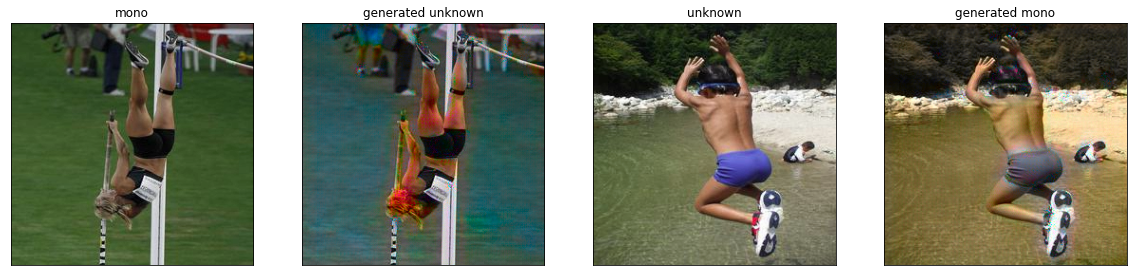

In [72]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
rgb_img = lch_to_rgb(np.moveaxis(np.array(winter.cpu()),0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("mono")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,2)
genImg = gen_S(winter)
genImg = np.array(torch.cat([winter[0,:,:].reshape((1,256,256)),genImg],axis=0).cpu().detach())
rgb_img = lch_to_rgb(np.moveaxis(genImg,0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("generated unknown")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,3)
rgb_img = lch_to_rgb(np.moveaxis(np.array(summer.cpu()),0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("unknown")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,4)
genImg = gen_W(summer)
genImg = np.array(torch.cat([summer[0,:,:].reshape((1,256,256)),genImg],axis=0).cpu().detach())
rgb_img = lch_to_rgb(np.moveaxis(genImg,0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("generated mono")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)